In [1]:
from mdss.ScoringFunctions.Bernoulli import Bernoulli
from mdss.ScoringFunctions.Poisson import Poisson
from mdss.MDSS import MDSS
import seaborn as sns

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings
 

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Example data
data = pd.DataFrame({
    'age': [25, 45, 35, 50, 23, 40, 55, 30, 60, 37],
    'bmi': [22, 27, 24, 29, 21, 26, 30, 23, 31, 28],
    'smoking': [0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
    'disease': [0, 1, 0, 1, 0, 1, 1, 0, 1, 0]
})

X = data[['age', 'bmi', 'smoking']]
y = data['disease']

model = LogisticRegression()
model.fit(X, y)

coefficients = model.coef_[0]
intercept = model.intercept_[0]

print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Coefficients: [ 0.82096077 -0.16803958  0.21848877]
Intercept: -27.381598832985656


In [61]:
predictor_names = ['age', 'bmi', 'smoking']
# Adjusted subset: let's consider high BMI (> 25) irrespective of smoking status
adjusted_subset = data[data['bmi'] > 25]
X_adjusted = adjusted_subset[['age', 'bmi', 'smoking']]
y_adjusted = adjusted_subset['disease']

# Fit the model on the adjusted divergent subset
model_adjusted = LogisticRegression()
model_adjusted.fit(X_adjusted, y_adjusted)

coefficients_adjusted = model_adjusted.coef_[0]
intercept_adjusted = model_adjusted.intercept_[0]

# Create a comparison dataframe
comparison_adjusted = pd.DataFrame({
    'Predictor': predictor_names,
    'Base Coefficients': coefficients,
    'Subset Coefficients': coefficients_adjusted
})

# Plotting the coefficients comparison
# fig, ax = plt.subplots(figsize=(10, 6))

# index = np.arange(len(predictor_names))
# bar_width = 0.35

# bars1 = ax.bar(index, coefficients, bar_width, label='Base Coefficients')
# bars2 = ax.bar(index + bar_width, coefficients_adjusted, bar_width, label='Subset Coefficients')

# ax.set_xlabel('Predictors')
# ax.set_ylabel('Coefficient Values')
# ax.set_title('Comparison of Logistic Regression Coefficients')
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(predictor_names)
# ax.legend()

# plt.tight_layout()
# plt.show()

comparison_adjusted


,Predictor,Base Coefficients,Subset Coefficients
0,age,0.820961,0.656666
1,bmi,-0.168040,-0.375573
2,smoking,0.218489,0.195333


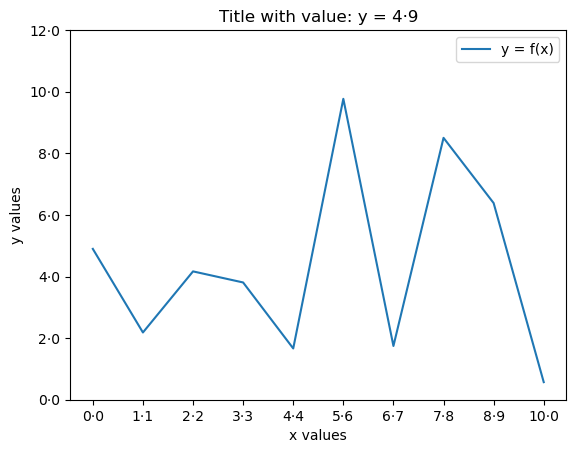

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample dataset
data = {
    'x': np.linspace(0, 10, 10),
    'y': np.random.uniform(0, 10, 10)
}
df = pd.DataFrame(data)

# Convert a value from the dataset to string with midpoint
def format_value(value):
    return f'{value:.1f}'.replace('.', '·')

# Format x and y tick labels
def format_ticks(values):
    return [format_value(val) for val in values]

# Create the plot
fig, ax = plt.subplots()
ax.plot(df['x'], df['y'], label='y = f(x)')

# Add title with formatted value from dataset
formatted_y_value = format_value(df['y'].iloc[0])  # Get first value for demonstration
ax.set_title(f'Title with value: y = {formatted_y_value}')

# Add labels
ax.set_xlabel('x values')
ax.set_ylabel('y values')

# Set formatted tick labels
ax.set_xticks(df['x'])
ax.set_xticklabels(format_ticks(df['x']))

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(format_ticks(ax.get_yticks()))

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [30]:
data = pd.read_csv('../sets/project2_data_26_02_24_autostrat1.csv').drop(columns = ['study_id']).fillna(-999)

target_cols = ['diabetes_status_c_phase1', 'ckd_c_phase1', 'cvd_status_phase1', 'hypertension_status_c_phase1']
data.head()

,age_phase1,site,sex,highest_level_of_education_phase1,partnership_status_c_phase1,ses_site_quintile_c_phase1,occupation_phase1,alcohol_use_status_c_phase1,smoking_status_c_phase1,diabetes_history_phase1,...,change_in_triglycerides,change_in_glucose,change_in_s_creatinine,change_in_insulin,change_in_non_hdl,change_in_egfr,change_in_acr,change_in_mvpa,MAP_phase1,MAP_phase2
0,45.0,3,1,2,1,4,1,3,0,0,...,-999.00,-999.00,-999.00,-999.0,-999.00,-999.000000,-999.000000,-999.0,88.166667,-999.000000
1,46.0,3,1,1,1,2,3,3,1,1,...,-999.00,-999.00,-999.00,-999.0,-999.00,-999.000000,-999.000000,-999.0,111.500000,-999.000000
2,57.0,1,0,0,2,2,2,0,0,0,...,-999.00,-999.00,-999.00,-999.0,-999.00,-999.000000,-999.000000,-999.0,87.500000,-999.000000
3,56.0,1,0,1,2,4,4,0,0,1,...,-999.00,-999.00,-999.00,-999.0,-999.00,-999.000000,-999.000000,-999.0,105.666667,-999.000000
4,56.0,1,1,1,2,2,4,3,2,0,...,-0.01,-0.47,15.88,-999.0,-0.73,-14.779267,-0.301724,2870.0,78.000000,62.666667


In [31]:
site_id = 1 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id)].fillna(-999)
# dff = dff2[(dff2['site'] == site_id)& (dff2['age_phase1'] <= 60) & (dff2['age_phase1'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)].copy()
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1465, 76)
Size after removing records with missing targets:  (1395, 76)


In [338]:
from IPython.display import Math,display, Markdown
Math(r'F(k) = \int_{-\infty}^{\infty} f(x) \cdot PP')

<IPython.core.display.Math object>

In [339]:
display(Math(r'Dims: {}x{}m \\ Area: {}m^2 \\ Volume: {}m^3'))

<IPython.core.display.Math object>

In [14]:
features = ['age_phase1', 'sex', 'highest_level_of_education_phase1',
       'partnership_status_c_phase1', 'ses_site_quintile_c_phase1',
       'occupation_phase1', 'alcohol_use_status_c_phase1',
       'smoking_status_c_phase1', 'diabetes_history_phase1', 'mvpa_c_phase1',
       'weight_phase1', 'bmi_c_phase1', 'waist_hip_r_c_phase1',
       'waist_circumference_phase1', 'bp_sys_average_phase1','bp_dia_average_phase1',
       'glucose_result_phase1', 's_creatinine_phase1',
       'hdl_phase1', 'cholesterol_1_phase1', 'friedewald_ldl_c_phase1',
       'triglycerides_phase1', 'egfr_c_phase1','acr_c_phase1']
continuous = ['weight_phase1', 'bmi_c_phase1', 'waist_hip_r_c_phase1',
       'waist_circumference_phase1', 'bp_sys_average_phase1','bp_dia_average_phase1',
       'glucose_result_phase1', 's_creatinine_phase1',
       'hdl_phase1', 'cholesterol_1_phase1', 'friedewald_ldl_c_phase1',
       'triglycerides_phase1', 'egfr_c_phase1','acr_c_phase1']

In [32]:
# dff.loc[:,'ckd_c_qcphase1'] = dff.loc[:,'ckd_c_qcphase1'].replace([-999], 0)
dff1 = dff.replace([-999, -222, -111, 999], np.nan).copy()

In [33]:
data.loc[(data['egfr_c_phase1'] == -999) & (data['site'] == 1)]

,age_phase1,site,sex,highest_level_of_education_phase1,partnership_status_c_phase1,ses_site_quintile_c_phase1,occupation_phase1,alcohol_use_status_c_phase1,smoking_status_c_phase1,diabetes_history_phase1,...,change_in_triglycerides,change_in_glucose,change_in_s_creatinine,change_in_insulin,change_in_non_hdl,change_in_egfr,change_in_acr,change_in_mvpa,MAP_phase1,MAP_phase2
51,43.0,1,0,1,1,4,4,1,0,0,...,-999.0,-999.00,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000
59,53.0,1,0,1,1,2,1,1,0,0,...,-999.0,-999.00,-999.0,-999.0,-999.0,-999.0,-7.478061,-160.0,100.166667,87.333333
78,54.0,1,0,1,2,3,2,0,0,0,...,-999.0,-999.00,-999.0,-999.0,-999.0,-999.0,0.595030,3250.0,96.666667,84.666667
94,41.0,1,0,0,1,4,3,1,0,0,...,-999.0,-999.00,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,118.166667,-999.000000
124,43.0,1,0,3,1,3,1,0,0,0,...,-999.0,-999.00,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,85.000000,-999.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261,57.0,1,0,1,1,4,4,0,0,0,...,-999.0,0.86,-999.0,-999.0,-999.0,-999.0,-4.653924,240.0,116.333333,96.000000
3271,43.0,1,0,1,1,1,4,0,0,0,...,-999.0,-999.00,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,81.333333,-999.000000
3285,53.0,1,1,1,1,4,4,0,0,-999,...,-999.0,-999.00,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000
3378,56.0,1,1,1,2,4,4,0,0,0,...,-999.0,-999.00,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,84.833333,-999.000000


In [24]:
# from sklearn.linear_model import BayesianRidge
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# import matplotlib.pyplot as plt
# imputer_bayes = IterativeImputer(
#     estimator=BayesianRidge(),
#     max_iter=10,
#     random_state=42)

# # let's create a MICE imputer using Bayes as estimator

# imputer = IterativeImputer(
#     estimator=BayesianRidge(), # the estimator to predict the NA
#     initial_strategy='mean', # how will NA be imputed in step 1
#     max_iter=10, # number of cycles
#     imputation_order='ascending', # the order in which to impute the variables
#     n_nearest_features=None, # whether to limit the number of predictors
#     skip_complete=True, # whether to ignore variables without NA
#     random_state=0,
# )
# imputer.fit(dff1)
# train_t = imputer.transform(dff1)
# # train_x = imputer.transform(data.iloc[:,2:])
# treated = pd.DataFrame(train_t, columns=dff1.columns)
# # treated = treated.apply(np.ceil)
# treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
#       = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# dff1['cimt_mean_max'].plot(kind='kde', ax=ax, color='blue')
# treated['cimt_mean_max'].plot(kind='kde', ax=ax, color='green')

In [34]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff1[continuous])
train_t = imputer.transform(dff1[continuous])
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff1[continuous].columns)
# treated = treated.apply(np.ceil)
# treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
#       = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)


/Users/kayadetunji/anaconda3/envs/kaymacmini/lib/python3.9/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


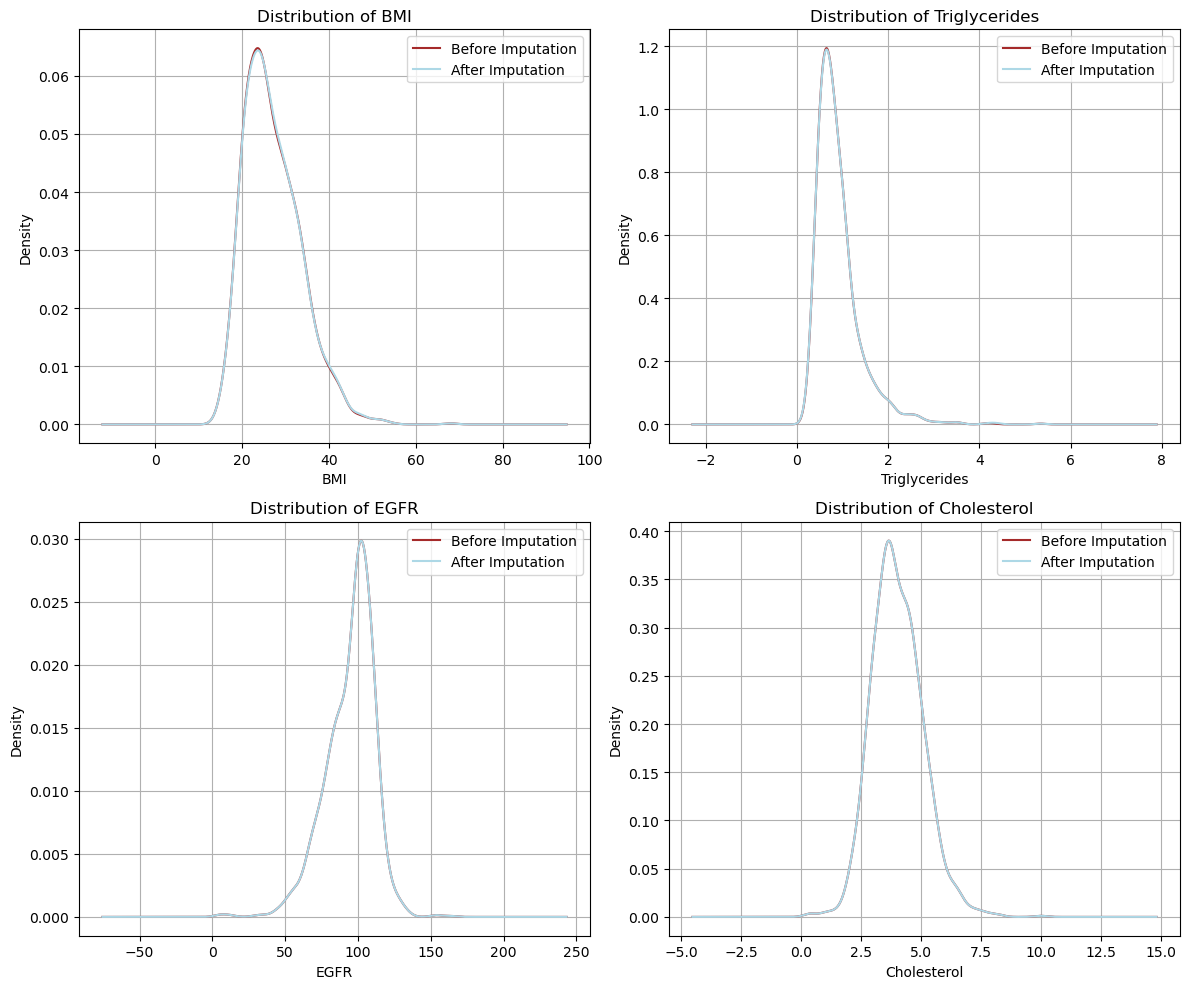

In [35]:
variables = {
    'bmi_c_phase1': 'BMI',
    'triglycerides_phase1': 'Triglycerides',
    'egfr_c_phase1': 'EGFR',
    'cholesterol_1_phase1': 'Cholesterol'
}
colors = ['brown', 'lightblue']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (var, var_name) in zip(axes, variables.items()):
    dff1[var].plot(kind='kde', ax=ax, color=colors[0], label='Before Imputation')
    treated[var].plot(kind='kde', ax=ax, color=colors[1], label='After Imputation')
    ax.set_title(f'Distribution of {var_name}')
    ax.set_xlabel(var_name)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
# Save the figure as .eps
fig.savefig("/Users/kayadetunji/Downloads/figs/distributions_ag.eps", format='eps')

# Save the figure as a vector-based PDF
fig.savefig("/Users/kayadetunji/Downloads/figs/distributions_ag.pdf", format='pdf')
plt.show()

In [36]:
dff = dff[features + target_cols].copy()
dff.reset_index(inplace=True, drop=True)
dff[continuous] = treated[continuous]
dff['age_phase1'] = dff.age_phase1.astype(int)

In [37]:
numeric_columns = [col for col in dff.columns \
                     if (is_numeric_dtype(dff[col])) \
                     & (col not in target_cols) \
                     & (dff[col].nunique() > 10)]

## Expected risks

In [38]:
# Specify the columns of interest
# columns_of_interest = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current'] 


# defining the outcome variable
dff['MorbidityCount'] = (dff[target_cols] == 1).sum(axis = 1) # *******CHECK*********
treated['MorbidityCount'] = (dff[target_cols] == 1).sum(axis = 1)

# Min-Max Normalization
# treated['normalizedOutcome'] = (treated['MorbidityCount'] - treated['MorbidityCount'].min()) / (treated['MorbidityCount'].max() - treated['MorbidityCount'].min())


# defining the expectations as mean of the target
# treated['expectation'] = treated[target_col].mean()
# treated['expectationPoisson'] = treated['normalizedOutcome'].mean()
treated['expectationPoisson'] = treated['MorbidityCount'].mean()
dff['expectationPoisson'] = dff['MorbidityCount'].mean()

In [39]:
dff[target_cols].astype(int)

,diabetes_status_c_phase1,ckd_c_phase1,cvd_status_phase1,hypertension_status_c_phase1
0,0,0,0,0
1,0,0,0,1
2,0,0,0,0
3,0,1,0,0
4,0,0,0,0
...,...,...,...,...
1390,0,0,0,1
1391,1,0,0,1
1392,0,0,0,0
1393,0,0,0,0


In [118]:
NA = dff

In [40]:
AG = dff

In [49]:
format_value(n[i][j]*100)

'0·052'

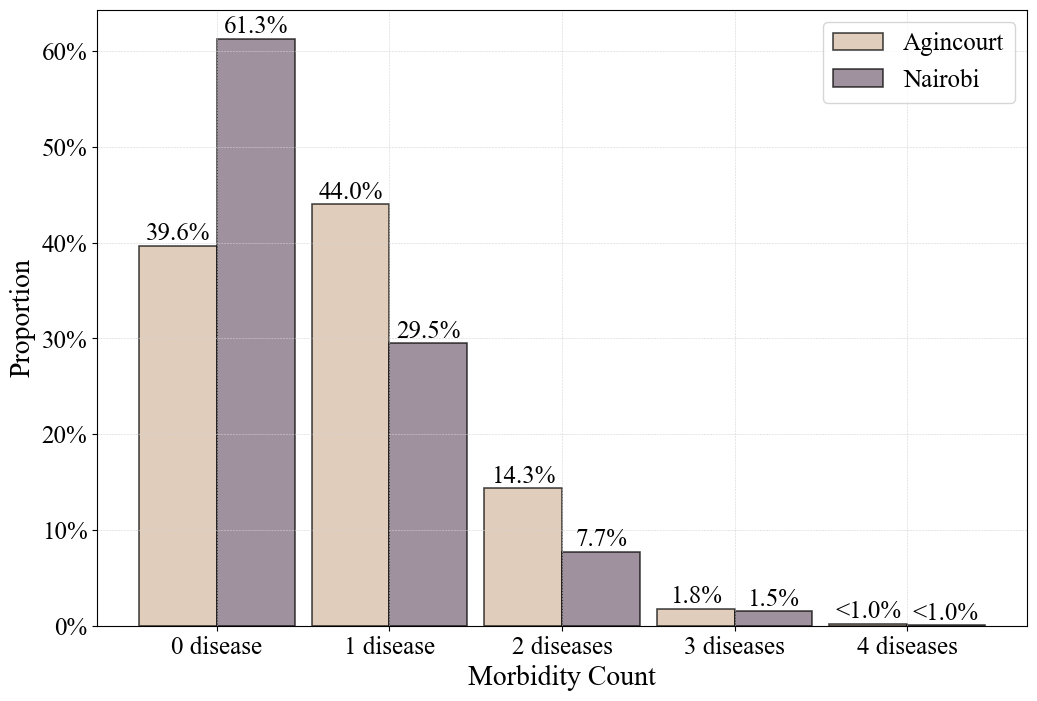

In [387]:
fig = plt.figure(figsize=(12,8))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
# plt.rcParams['text.usetex'] = True

# formatted_y_value = format_value(df['y'].iloc[0])  # Get first value for demonstration
# ax.set_title(f'Title with value: y = {formatted_y_value}')
# Create a grouped histogram
bins = np.arange(6) - 0.5 # Defining bins edges so that integers are centered
n, bins, patches = plt.hist([AG.MorbidityCount, NA.MorbidityCount], bins=bins, alpha=0.7, label=['Agincourt', 'Nairobi'], color=['#D3B99F', '#776274'], edgecolor='black', linewidth=1.2, density=True, rwidth=0.9)
# Calculating the width of each bin to properly align text labels
bin_width = np.diff(bins)[0]
bar_width = bin_width * 0.9 / 4  # Assuming rwidth=0.9 and 3(4) groups

for i in range(len(n)):  # There are 2 groups
    for j in range(len(bins)-1):  # There are 5 bins, but len(bins)-1 gives the number of intervals
        # Calculate the center of each bar more accurately for 2 groups
        bar_center = bins[j] + bin_width/2 + (i - 0.5) * bin_width * 0.9 / 2  # Adjust for 2 groups
        
        # Condition to check the visibility and apply annotations
        if n[i][j] >= 0.01:  # For visible bars, annotate the percentage
            plt.text(bar_center, n[i][j], f'{n[i][j]*100:.1f}%', ha='center', va='bottom')
        else:  # For very small values, annotate as "<1.0"
            plt.text(bar_center, n[i][j], '<1.0%', ha='center', va='bottom')
            
# ax.set_xticks(df['x'])
# ax.set_xticklabels(format_ticks(df['x']))
plt.xlabel('Morbidity Count', fontsize= 20)
plt.ylabel('Proportion', fontsize= 20)
# plt.title('Grouped Histogram of Morbidity Count by Subset')
plt.xticks(ticks=np.arange(5), labels=['0 disease', '1 disease', '2 diseases', '3 diseases', '4 diseases'])  # Setting custom x-ticks to align with the morbidity counts
# plt.xlim(-0.5, 4.5) 
plt.yticks(ticks=np.arange(0.0,0.7,0.1), labels=['0%', '10%', '20%', '30%', '40%', '50%', '60%'])
# Turning off y-axis ticks and labels
y_ticks = plt.yticks()[0] * 100 
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.4)
plt.legend()
fig.savefig("/Users/kayadetunji/Downloads/figs/sites_distribution.pdf", format='pdf')
plt.show()

In [268]:
AG[['diabetes_status_c_phase1', 'hypertension_status_c_phase1', 'cvd_status_phase1', 'ckd_c_phase1']]

,diabetes_status_c_phase1,hypertension_status_c_phase1,cvd_status_phase1,ckd_c_phase1
0,0,0,0.0,0.0
1,0,1,0.0,0.0
2,0,0,0.0,0.0
3,0,0,0.0,1.0
4,0,0,0.0,0.0
...,...,...,...,...
1390,0,1,0.0,0.0
1391,1,1,0.0,0.0
1392,0,0,0.0,0.0
1393,0,0,0.0,0.0


In [194]:
df = dff

In [310]:
# Define the variables to include based on the provided dataset and instructions
continuous_vars = ['age_phase1']
categorical_vars = [
    'hypertension_status_c_phase1',
    'diabetes_status_c_phase1',
    'ckd_c_phase1',
    'cvd_status_phase1',
]

# Group by MorbidityCount
grouped = df.groupby('MorbidityCount')

# Initialize a results dictionary
results = {'Variables': [], 'Original data (N = {})'.format(len(df)): []}
for count in range(5):
    results[f'MorbidityCount = {count} (N = {grouped.size().get(count, 0)})'] = []

# For continuous variables, compute mean and std
for var in continuous_vars:
    results['Variables'].append(var)
    results['Original data (N = {})'.format(len(df))].append(f"{df[var].mean():.2f} ± {df[var].std():.2f}")
    for count in range(5):
        if count in grouped.groups:
            count_data = grouped.get_group(count)[var]
            results[f'MorbidityCount = {count} (N = {len(count_data)})'].append(f"{count_data.mean():.2f} ± {count_data.std():.2f}")
        else:
            results[f'MorbidityCount = {count} (N = 0)'].append('N/A')

# For categorical variables, compute count and percentage
for var in categorical_vars:
    results['Variables'].append(var)
    total_count = df[var].value_counts().to_dict()
    results['Original data (N = {})'.format(len(df))].append(f"{total_count.get(1, 0)} ({total_count.get(1, 0) / len(df) * 100:.2f}%)")
    for count in range(5):
        if count in grouped.groups:
            count_data = grouped.get_group(count)[var].value_counts().to_dict()
            results[f'MorbidityCount = {count} (N = {len(grouped.get_group(count))})'].append(f"{count_data.get(1, 0)} ({count_data.get(1, 0) / len(grouped.get_group(count)) * 100:.2f}%)")
        else:
            results[f'MorbidityCount = {count} (N = 0)'].append('N/A')

# Convert results to DataFrame for better display
results_df3 = pd.DataFrame(results)

results_df3

,Variables,Original data (N = 1395),MorbidityCount = 0 (N = 553),MorbidityCount = 1 (N = 614),MorbidityCount = 2 (N = 200),MorbidityCount = 3 (N = 25),MorbidityCount = 4 (N = 3)
0,age_phase1,50.91 ± 5.90,49.29 ± 5.86,51.56 ± 5.71,52.95 ± 5.59,53.76 ± 4.73,57.33 ± 1.53
1,hypertension_status_c_phase1,726 (52.04%),0 (0.00%),503 (81.92%),195 (97.50%),25 (100.00%),3 (100.00%)
2,diabetes_status_c_phase1,89 (6.38%),0 (0.00%),15 (2.44%),50 (25.00%),21 (84.00%),3 (100.00%)
3,ckd_c_phase1,221 (15.84%),0 (0.00%),78 (12.70%),117 (58.50%),23 (92.00%),3 (100.00%)
4,cvd_status_phase1,65 (4.66%),0 (0.00%),18 (2.93%),38 (19.00%),6 (24.00%),3 (100.00%)


In [311]:
results_df3.to_csv('nai.csv', index=False)

In [ ]:
# Re-importing necessary libraries due to execution environment reset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


df1 = pd.DataFrame()
df2 = pd.DataFrame()

df1[['Diabetes', 'Hypertension', 'CVD', 'CKD']] = AG[['diabetes_status_c_phase1', 'hypertension_status_c_phase1', 'cvd_status_phase1', 'ckd_c_phase1']]
df2[['Diabetes', 'Hypertension', 'CVD', 'CKD']] = NA[['diabetes_status_c_phase1', 'hypertension_status_c_phase1', 'cvd_status_phase1', 'ckd_c_phase1']]

# Function to calculate pairwise combinations percentages
def calculate_pairwise_percentages(df):
    pairwise_combinations = {}
    for disease1 in df.columns:
        for disease2 in df.columns:
            if disease1 < disease2:  # Avoid repeating combinations and comparing the same disease
                combination_name = f"{disease1}/{disease2}"
                # Calculate the presence of both diseases in the individuals
                pairwise_combinations[combination_name] = np.sum((df[disease1] == 1) & (df[disease2] == 1)) / len(df) * 100
    return pairwise_combinations

percentages1 = calculate_pairwise_percentages(df1)
percentages2 = calculate_pairwise_percentages(df2)
disease_name_mapping = {
    'hypertension_status_c_phase1/diabetes_status_c_phase1': 'HT/DM',
    'hypertension_status_c_phase1/cvd_status_phase1': 'HT/CVD',
    'hypertension_status_c_phase1/ckd_c_phase1': 'HT/CKD',
    'diabetes_status_c_phase1/cvd_status_phase1': 'DM/CVD',
    'diabetes_status_c_phase1/ckd_c_phase1': 'DM/CKD',
    'cvd_status_phase1/ckd_c_phase1': 'CVD/CKD'
}
shortened_labels = list(disease_name_mapping.keys())

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
# ind = np.arange(len(percentages1))  # the x locations for the groups
# width = 0.35  # the width of the bars

# # ax.bar(ind - width/2, list(percentages1.values()), width, label='Population 1', color='skyblue')
# # ax.bar(ind + width/2, list(percentages2.values()), width, label='Population 2', color='salmon')

# bars1 = ax.bar(ind - width/2, list(percentages1.values()), width, label='Agincourt', color='#D3B99F')
# bars2 = ax.bar(ind + width/2, list(percentages2.values()), width, label='Nairobi', color='#776274')

# # Add some text for labels, title, and custom x-axis tick labels
# ax.set_xlabel('Pairwaise diseases')
# ax.set_ylabel('Percentage of Individuals (%)')
# ax.set_title('Percentage of Individuals with Each Pairwise Disease Combination for Two Populations')
# ax.set_xticks(ind)
# ax.set_xticklabels(percentages1.keys(), rotation=30)
# ax.legend()

# plt.show()
# Calculate positions for each bar
y_positions = np.arange(len(shortened_labels))

# Plot horizontal bars for Population 1 and Population 2 side by side
ax.barh(y_positions - width/2, list(percentages1.values()), height=width, label='Agincourt', color='#D3B99F')
ax.barh(y_positions + width/2, list(percentages2.values()), height=width, label='Nairobi', color='#776274')

# Labeling
ax.set_xlabel('Percentage of Individuals (%)')
# ax.set_title('Percentage of Individuals with Each Pairwise Disease Combination')
ax.set_yticks(y_positions)
ax.set_yticklabels(percentages1.keys())
ax.legend()

plt.tight_layout()
plt.show()


In [131]:
AG[(AG['diabetes_status_c_phase1'] == 1)& (AG['ckd_c_phase1'] == 1) ].shape[0]/AG.shape[0]*100

1.7204301075268817

In [119]:
NA[(NA['diabetes_status_c_phase1'] == 1)& (NA['ckd_c_phase1'] == 1) ].shape[0]/NA.shape[0]*100

1.5987622485817432

In [ ]:
NA.plot(kind='kde', color='blue')

In [106]:
list(disease_name_mapping.values())

['HT/DM', 'HT/CVD', 'HT/CKD', 'DM/CVD', 'DM/CKD', 'CVD/CKD']

In [84]:
ang1_up = dff_encoded.mask(dff_encoded == 1, np.nan)
# ang1

In [85]:
ang1_up.iloc[:,0:]

,DC_0,DC_1,DC_2,DC_3,DC_4
0,NaN,0.0,0.0,0.0,0.0
1,0.0,NaN,0.0,0.0,0.0
2,NaN,0.0,0.0,0.0,0.0
3,0.0,NaN,0.0,0.0,0.0
4,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1390,0.0,NaN,0.0,0.0,0.0
1391,0.0,0.0,NaN,0.0,0.0
1392,NaN,0.0,0.0,0.0,0.0
1393,NaN,0.0,0.0,0.0,0.0


In [364]:
treated['MorbidityCount'].mean()

0.789247311827957

In [ ]:
from matplotlib.patches import Circle, Wedge

# Sample DataFrame
df = pd.DataFrame({
    'x_col': treated[treated['MorbidityCount'] != 0].age, 
    'y_col': treated[treated['MorbidityCount'] != 0].bmi_c_qc,
    'outcome': treated[treated['MorbidityCount'] != 0].MorbidityCount
})

# Function to draw custom markers
def draw_custom_marker(ax, x, y, outcomes):
    radius = 0.2  # Adjust size of the custom marker
    colors = ['cyan', 'red', 'teal', 'green']
    
    if outcomes == 1:
        circle = Circle((x, y), radius, color=colors[0], transform=ax.transData)
        ax.add_patch(circle)
    elif outcomes == 2:
        wedge1 = Wedge((x, y), radius, 40, 220, color=colors[0], transform=ax.transData)
        wedge2 = Wedge((x, y), radius, 220, 39, color=colors[1], transform=ax.transData)
        ax.add_patch(wedge1)
        ax.add_patch(wedge2)
    elif outcomes == 3:
        wedge1 = Wedge((x, y), radius, 0, 120, color=colors[0], transform=ax.transData)
        wedge2 = Wedge((x, y), radius, 120, 240, color=colors[1], transform=ax.transData)
        wedge3 = Wedge((x, y), radius, 240, 360, color=colors[2], transform=ax.transData)
        ax.add_patch(wedge1)
        ax.add_patch(wedge2)
        ax.add_patch(wedge3)
    elif outcomes == 4:
        wedge1 = Wedge((x, y), radius, 10, 100, color=colors[0], transform=ax.transData)
        wedge2 = Wedge((x, y), radius, 100, 190, color=colors[1], transform=ax.transData)
        wedge3 = Wedge((x, y), radius, 190, 280, color=colors[2], transform=ax.transData)
        wedge4 = Wedge((x, y), radius, 280, 9, color=colors[3], transform=ax.transData)
        ax.add_patch(wedge1)
        ax.add_patch(wedge2)
        ax.add_patch(wedge3)
        ax.add_patch(wedge4)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
# ax.scatter(df['x_col'], df['y_col'], alpha=0.5)

# Iterate through DataFrame to plot each custom marker
for index, row in df.iterrows():
    draw_custom_marker(ax, row['x_col'], row['y_col'], row['outcome'])

plt.title('Scatter Plot with Custom Markers')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(40, 62)
plt.ylim(0, 65)
plt.show()

In [27]:
df

,x_col,y_col,outcome
1,27.02,4.45,1
3,37.42,4.05,1
6,23.62,2.59,1
7,36.42,4.12,1
8,20.81,4.44,1
...,...,...,...
1457,29.21,4.60,1
1458,34.00,4.28,1
1459,22.09,2.69,1
1460,15.82,4.84,1


In [41]:
zeroCount = treated.loc[treated['MorbidityCount'] == 0]
OneCount = treated.loc[treated['MorbidityCount'] == 1]
twoCount = treated.loc[treated['MorbidityCount'] == 2]
threeCount = treated.loc[treated['MorbidityCount'] == 3]
fourCount = treated.loc[treated['MorbidityCount'] == 4]

print(len(zeroCount['MorbidityCount']), len(OneCount['MorbidityCount']), len(twoCount['MorbidityCount']), len(threeCount['MorbidityCount']), len(fourCount['MorbidityCount']))
len(OneCount['MorbidityCount'])

553 614 200 25 3


614

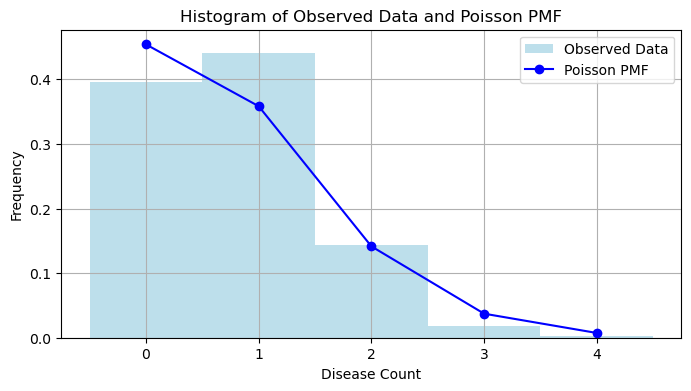

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson

# Example data
poisData = treated['MorbidityCount']

# Calculate lambda (λ) as the mean of the data
lambda_ = np.mean(poisData)

# Generate the range of possible count values (up to the max observed count)
x = np.arange(0, max(poisData) + 1)

# Calculate the Poisson probability mass function (PMF) for each count
pmf = poisson.pmf(x, lambda_)

# Plotting
plt.figure(figsize=(8, 4))
plt.hist(poisData, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.8, color='lightblue', label='Observed Data')
plt.plot(x, pmf, 'o-', color='blue', label='Poisson PMF')
plt.title('Histogram of Observed Data and Poisson PMF')
plt.xlabel('Disease Count')
plt.ylabel('Frequency')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()


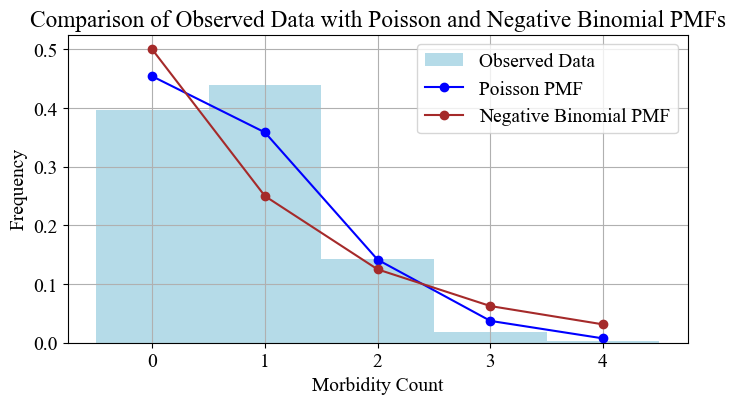

0.7429961032492521

In [366]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom

# Poisson model
lambda_poisson = np.mean(poisData)

# Calculating the mean and variance for the Negative Binomial distribution
mean_negbin = np.mean(poisData)
variance_negbin = np.var(poisData)

# The dispersion parameter (r) for the Negative Binomial distribution
# r = mean^2 / (variance - mean) for overdispersed data
r_negbin = mean_negbin**2 / (variance_negbin - mean_negbin) if variance_negbin > mean_negbin else 1

# Probability of success (p) for the Negative Binomial distribution
p_negbin = mean_negbin / variance_negbin if variance_negbin > mean_negbin else 0.5

# Generate range for count values
x = np.arange(0, max(poisData) + 1)

# Poisson PMF
pmf_poisson = poisson.pmf(x, lambda_poisson)

# cp -i -a /Users/kayadetunji/Downloads/HAALSI_work/mdscan-master/Poisson_scoring.ipynb /Users/kayadetunji/.ssh/ kayode@cream-ce.core.wits.ac.za:/spaces/freedom/kay/HAALSI_Subset_DDI.pdf  
# Negative Binomial PMF
pmf_negbin = nbinom.pmf(x, r_negbin, p_negbin)

# Plotting
plt.figure(figsize=(8,4))
plt.hist(poisData, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.9, color='lightblue', label='Observed Data')
plt.plot(x, pmf_poisson, 'o-', color='blue', label='Poisson PMF')
plt.plot(x, pmf_negbin, 'o-', color='brown', label='Negative Binomial PMF')
plt.title('Comparison of Observed Data with Poisson and Negative Binomial PMFs')
plt.xlabel('Morbidity Count')
plt.ylabel('Frequency')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()

# Calculate Dispersion Statistic
dispersion_statistic = variance_negbin / mean_negbin
dispersion_statistic



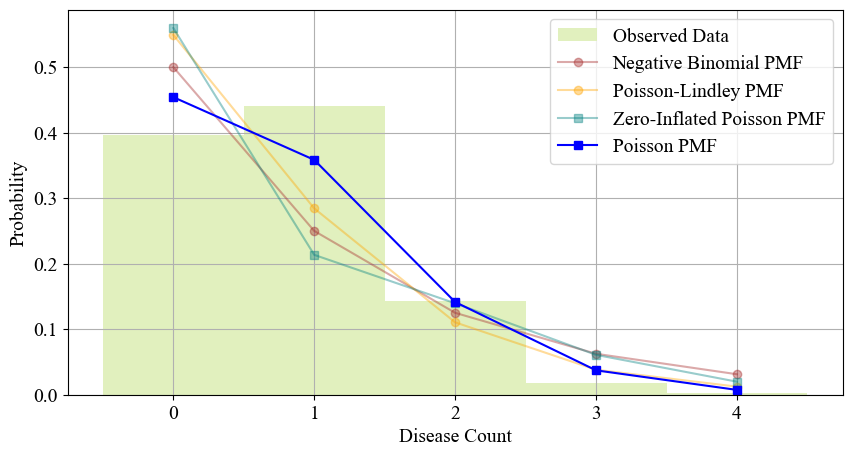

In [367]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom, geom, binom
from scipy.special import factorial
from scipy.optimize import fsolve

# Function to calculate mean of Poisson-Lindley given theta
def pois_lindley_mean(theta):
    return (2*theta + 3) / (theta * (1 + theta))

# Function to solve for theta given the sample mean
def solve_theta(sample_mean):
    # Equation to solve: sample_mean = (2*theta + 3) / (theta * (1 + theta))
    func = lambda theta: pois_lindley_mean(theta) - sample_mean
    theta_initial_guess = 1.0
    theta_solution, = fsolve(func, theta_initial_guess)
    return theta_solution

# Sample mean of poisData
sample_mean = np.mean(poisData)

# Solve for theta
theta_estimated = solve_theta(sample_mean)

# Generate Poisson-Lindley PMF based on estimated theta
def pois_lindley_pmf(k, theta):
    return theta**2 * (1 + k) / (1 + theta)**(k + 2)

# Generate range for count values
x = np.arange(0, max(poisData) + 1)

# Calculate PMF values
pmf_pois_lindley = [pois_lindley_pmf(k, theta_estimated) for k in x]
lambda_poisson = np.mean(poisData)
mean_negbin = np.mean(poisData)
variance_negbin = np.var(poisData)
r_negbin = mean_negbin**2 / (variance_negbin - mean_negbin) if variance_negbin > mean_negbin else 1
p_negbin = mean_negbin / variance_negbin if variance_negbin > mean_negbin else 0.5
x = np.arange(0, max(poisData) + 1)

# ZIP Parameters (simplified for illustration)
pi = sum(poisData == 0) / len(poisData)
lambda_zip = np.mean(poisData[poisData > 0])

# ZIP PMF function
def zip_pmf(x, pi, lambda_zip):
    if x == 0:
        return pi + (1 - pi) * np.exp(-lambda_zip)
    else:
        return (1 - pi) * poisson.pmf(x, lambda_zip)

# Generating ZIP PMF values
pmf_zip = np.array([zip_pmf(xi, pi, lambda_zip) for xi in x])

# Plotting
fig = plt.figure(figsize=(10,5))
plt.hist(poisData, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.9, color='#DEEFB7', label='Observed Data')
plt.plot(x, pmf_negbin, 'o-', color='brown', alpha=0.4, label='Negative Binomial PMF')
plt.plot(x, pmf_pois_lindley, 'o-', color='orange', alpha=0.4, label='Poisson-Lindley PMF')
# plt.title('Comparison of Observed Data with Poisson-Lindley PMF')
plt.plot(x, pmf_zip, 's-', color='teal', alpha=0.4, label='Zero-Inflated Poisson PMF')
plt.plot(x, pmf_poisson, 's-', color='blue', label='Poisson PMF')
# plt.title('Comparison of Observed Data with Multiple Distribution PMFs')
plt.xlabel('Disease Count')
plt.ylabel('Probability')
plt.xticks(x)
plt.legend()
plt.grid()

# fig.savefig("/Users/kayadetunji/Downloads/figs/pmf_na.eps", format='eps')
# fig.savefig("/Users/kayadetunji/Downloads/figs/pmf_na.pdf", format='pdf')
plt.show()


In [24]:
import scipy.stats as stats

# Example data for Group 1 and Group 2
# data_group1 = np.array([1, 0, 2, 1, 3, 0, 4, 1, 0, 2])
# data_group2 = np.array([0, 1, 1,  0, 1, 1, 0])

# Example data for Group 1 and Group 2
data_group1 = np.array([1, 0])
data_group2 = np.array([1, 0, 2, 1, 3, 0, 4, 1, 0, 2])

# Min-Max Normalization
dg_norm1 = (data_group1 - data_group1.min()) / (data_group1.max() - data_group1.min())
dg_norm2 = (data_group2 - data_group2.min()) / (data_group2.max() - data_group2.min())

person_time_group1 = np.mean(data_group1)
person_time_group2 = np.mean(data_group2)

# Calculate incidence densities
incidence_density_group1 = np.sum(data_group1) / person_time_group1
incidence_density_group2 = np.sum(data_group2) / person_time_group2
# Calculate incidence densities
# incidence_density_group1 = data_group1.size / person_time_group1
# incidence_density_group2 = data_group2.size / person_time_group2

# Calculate IDR
# IDR = incidence_density_group1 / incidence_density_group2
IDR = person_time_group1 / person_time_group2

# Standard errors of the log incidence densities
se_log_id1 = np.sqrt(1 / np.sum(data_group1))
se_log_id2 = np.sqrt(1 / np.sum(data_group2))

# Standard error of the log IDR
se_log_idr = np.sqrt(se_log_id1**2 + se_log_id2**2)

# Confidence interval
z_score = stats.norm.ppf(0.975)  # For a 95% confidence interval
ci_lower = np.exp(np.log(IDR) - z_score * se_log_idr)
ci_upper = np.exp(np.log(IDR) + z_score * se_log_idr)

# Statistical significance
significance = "not significant" if ci_lower <= 1 <= ci_upper else "significant"

print(f"IDR: {IDR}")
print(f"95% Confidence Interval: [{ci_lower}, {ci_upper}]")
print(f"The difference is {significance}.")


IDR: 0.35714285714285715
95% Confidence Interval: [0.0469639552014967, 2.7159343769261235]
The difference is not significant.


In [184]:

# Example data
data_group1 = np.array([1, 0, 2, 1, 3, 0, 4, 1, 0, 2])
data_group2 = np.array([0, 1, 1,  0, 1, 1, 0])

# Min-Max Normalization
dg_norm1 = (data_group1 - data_group1.min()) / (data_group1.max() - data_group1.min())
dg_norm2 = (data_group2 - data_group2.min()) / (data_group2.max() - data_group2.min())

# Total cases for each group
cases_group1 = np.sum(data_group1)
cases_group2 = np.sum(data_group2)

# Assuming equal person-time for simplicity
person_time_group1 = np.mean(data_group1)
person_time_group2 = np.mean(data_group2)

# Calculate Incidence Density for each group
incidence_density_group1 = cases_group1 / person_time_group1
incidence_density_group2 = cases_group2 / person_time_group2

# Calculate IDR
IDR = incidence_density_group1 / incidence_density_group2

# Calculate Log-IDR and its standard error
log_IDR = np.log(IDR)
SE_log_IDR = np.sqrt((1/cases_group1) + (1/cases_group2))

# Calculate 95% Confidence Interval for Log-IDR
CI_lower_log = log_IDR - 1.96 * SE_log_IDR
CI_upper_log = log_IDR + 1.96 * SE_log_IDR

# Transform the CI back to the original scale
CI_lower = np.exp(CI_lower_log)
CI_upper = np.exp(CI_upper_log)

# Z-test for significance
Z_score = log_IDR / SE_log_IDR
p_value = stats.norm.sf(abs(Z_score)) * 2  # Two-tail test

print("Incidence Density Ratio (IDR):", IDR)
print("95% Confidence Interval:", CI_lower, CI_upper)
print("Z-score:", Z_score)
print("P-value:", p_value)


Incidence Density Ratio (IDR): 1.4285714285714286
95% Confidence Interval: 0.47022658405755985 4.340070076260934
Z-score: 0.6291154670331937
P-value: 0.5292734652386912


In [18]:
# Defining the search space to be all the features except site, study_id, 
# and our created target_col and expectations columns

search_space = [col for col in treated.columns \
                if col not in \
                ['MorbidityCount', 'normalizedOutcome','site', 'study_id', 'expectationPoisson', 
                'htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current', 'cimt_mean_max']]

In [19]:
# Defining the search space to be all the features except site, study_id, 
# and our created target_col and expectations columns

search_space1 = [col for col in dff.columns \
                if col not in \
                ['age_phase2','index','site',
       'diabetes_status_c_phase2', 'hypertension_status_phase2',
       'smoking_status_c_phase2', 'diabetes_history_phase2', 'mvpa_c_phase2',
       'weight_phase2', 'bmi_c_phase2', 'waist_circumference_phase2',
       'waist_hip_r_c_phase2', 'bp_sys_average_phase2','hypertension_status_c_phase1','diabetes_status_c_phase1','non_hdl_c_phase1',
       'bp_dia_average_phase2', 'fasting_confirmed_phase2','hip_circumference_phase1', 'hip_circumference_phase2',
       'glucose_result_phase2', 's_creatinine_phase2', 'insulin_result_phase2', 'cholesterol_1_phase2', 'friedewald_ldl_c_phase2',
       'triglycerides_phase2', 'non_hdl_c_phase2', 'egfr_c_phase2','acr_c_phase2', 'change_in_weight', 'change_in_bmi',
       'change_in_waist_hip_ratio', 'change_in_waist_circf','change_in_systolic_ave', 'change_in_diastolic_ave',
       'change_in_cholesterol', 'change_in_friedewald', 'change_in_hdl', 'bp_sys_average_phase1',
       'change_in_triglycerides', 'change_in_glucose','ckd_c_phase1', 'bp_dia_average_phase1', 'acr_c_phase1',
 'cvd_status_phase1','insulin_result_phase1','hdl_phase2','fasting_confirmation_phase1','weight_phase1','partnership_status_c_phase1',
       'change_in_s_creatinine', 'change_in_insulin', 'change_in_non_hdl','s_creatinine_phase1', 'glucose_result_phase1', 
       'change_in_egfr', 'change_in_acr', 'change_in_mvpa', 'MAP_phase1',#'diabetes_history_phase1', 'mvpa_c_phase1', 
       'MAP_phase2', 'MorbidityCount', 'expectationPoisson']]

In [171]:
print(search_space1)

['age_phase1', 'sex', 'highest_level_of_education_phase1', 'ses_site_quintile_c_phase1', 'occupation_phase1', 'alcohol_use_status_c_phase1', 'smoking_status_c_phase1', 'diabetes_history_phase1', 'mvpa_c_phase1', 'bmi_c_phase1', 'waist_hip_r_c_phase1', 'waist_circumference_phase1', 'hdl_phase1', 'cholesterol_1_phase1', 'friedewald_ldl_c_phase1', 'triglycerides_phase1', 'egfr_c_phase1']


In [43]:
def get_str(x):
    # This function turns a pandas bin to a meaningful string
    s = str(round(x.left, 2)) + ' - ' + str(round(x.right,2))
    return s

def custom_qcut(ser, contiguous = True):
    # Get the rows that are actual numbers
    sub_ser = ser[(ser != -111) \
                     & (ser != -222) \
                     & (ser != -555) \
                     & (ser != -999)]
    
    if contiguous:
        # if contiguous, treat all the special numbers the same
        ser = ser.replace(-111 , -999)
        ser = ser.replace(-222 , -999)
        ser = ser.replace(-555 , -999)

    # Bin the actual numbers into 10 bins for scanning
    sub_ser = pd.qcut(sub_ser, 10, duplicates='drop')
    sub_ser = sub_ser.apply(get_str).astype(str)
    ser[list(sub_ser.index)] = sub_ser
    return ser
            

In [44]:
contiguous = {}
dff_2 = dff.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space1:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [45]:
def compress_contiguous(subset, contiguous):
    # Shorten a contiguous list e.g [0-9, 10-19] is converted to [0 - 19] 
    new = {}
    
    for col in subset:
        if col in contiguous:
            if isinstance(subset[col][0], (float,int)):
                new[col] = [str(c) for c in subset[col]]
                continue
            i = -1 if isinstance(subset[col][-1], str) else -2
            new[col] = [subset[col][0].split(' - ')[0] + ' - ' + subset[col][i].split(' - ')[-1]]
            new[col] = new[col] if i == -1 else new[col] + [str(subset[col][-1])]
        else:
            new[col] = [str(c) for c in subset[col]]
    return new

def translate_subset_to_rule(subset):
    # Print the subset as a rule for easier understanding
    desc = ''
    for key, value in subset.items():
        # desc += key + ' = {' + ' OR '.join(value) + '} AND' + '\n'
        desc += key + '{' + ' OR '.join(value) + '} AND' + ' '

    return desc[:-5].replace('_',' ').replace('{', '[').replace('}', ']')

def count_conditions(subset):
    # Split the string by 'AND' and 'OR'
    conditions = subset.replace("AND", "OR").split("OR")
    
    # Count the number of conditions
    condition_count = len(conditions)
    
    return condition_count

In [77]:
# %%time

import scipy.stats as stats

# Scan in the positive direction using defined penalties and num iters

scoring_function = Poisson(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
# penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 10]
# penalty_values = [0.3, 0.8, 1.0, 2.1, 3.5,4.5,5.5,6.5,7.5] # High risk Nairobi 
# penalty_values = [0.05, 0.1, 0.2, 0.5,0.8, 1.0,2.0,3.5, 4.5, 6.5, 9.5] # Low risk 
penalty_values = [0.05, 0.4, 0.5, 0.8, 1.0,2.0,3.5, 4.0, 4.5] # High risk
# penalty_values = [0.13, 0.8, 1.0, 3.5, 8.5,20.5] # Low risk
num_iters = 10
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
IDR_results = []
count_results = []
z_scores = []
p_values = []
disease_counts = []
counts_percent = []
size_percent = []
dataframes = {}
dataframes_complement = {}

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space1], dff_2['MorbidityCount'], dff_2['expectationPoisson'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]
    not_temp_df = dff_2.loc[~to_choose]
    size = len(temp_df)

    # Store each DataFrame in the dictionary with a unique key
    dataframes[f'df_{penalty}'] = temp_df
    dataframes_complement[f'df_{penalty}'] = not_temp_df

    # 
    expected_risk_subset = temp_df['MorbidityCount'].mean()
    expected_risk = dff_2['MorbidityCount'].mean()  

    # Total number of events (sum of counts)
    total_events_subset = temp_df['MorbidityCount'].sum()
    total_events = dff_2['MorbidityCount'].sum()

    # Calculate incidence density
    incidence_density_subset = total_events_subset / len(temp_df)
    incidence_density = total_events / len(dff_2)

    #Calc IDR
    IDR = incidence_density_subset/incidence_density

    # Calculate Log-IDR and its standard error
    log_IDR = np.log(IDR)
    SE_log_IDR = np.sqrt((1/total_events_subset) + (1/total_events))

    # Calculate 95% Confidence Interval for Log-IDR
    CI_lower_log = log_IDR - 1.96 * SE_log_IDR
    CI_upper_log = log_IDR + 1.96 * SE_log_IDR

    # Transform the CI back to the original scale
    CI_lower = np.exp(CI_lower_log)
    CI_upper = np.exp(CI_upper_log)

    # Z-test for significance
    Z_score = log_IDR / SE_log_IDR
    # Two-tail test
    p_value = stats.norm.sf(abs(Z_score)) * 2 

    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(np.round(score, 3))
    size_percent.append(np.round((len(temp_df)/len(dff_2)*100),2))
    counts_percent.append(np.round((total_events_subset/total_events*100),2))
    size_results.append(size)
    IDR_results.append(np.round(IDR, 3))
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)
    z_scores.append(Z_score)
    p_values.append(p_value)
    disease_counts.append(total_events_subset)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, \
          IDR = {IDR_results[i]}, Score = {score_results[i]}, Z_score = {z_scores[i]}, Disease_counts = {disease_counts[i]}, \
          Size_percent = {size_percent[i]},Count_percent = {counts_percent[i]},P_value = {p_values[i]}")

Penalty = 0.05: Subset = triglycerides phase1[1.0 - 5.34] AND hdl phase1[1.06 - 3.78] AND friedewald ldl c phase1[1.67 - 7.6] AND bmi c phase1[21.46 - 68.02] AND waist hip r c phase1[0.86 - 1.16] AND diabetes history phase1[1], 
LiteralsNumber = 6, 
Size = 31,           IDR = 2.657, Score = 22.677, Z_score = 7.654718791289948, Disease_counts = 65,           Size_percent = 2.22,Count_percent = 5.9,P_value = 1.9373570978585514e-14
Penalty = 0.4: Subset = occupation phase1[-999 OR 1 OR 3 OR 4] AND waist hip r c phase1[0.9 - 1.16] AND age phase1[53.0 - 70.0] AND triglycerides phase1[0.46 - 5.34] AND bmi c phase1[21.46 - 68.02], 
LiteralsNumber = 8, 
Size = 239,           IDR = 1.606, Score = 26.035, Z_score = 7.305655560380215, Disease_counts = 303,           Size_percent = 17.13,Count_percent = 27.52,P_value = 2.759181537083183e-13
Penalty = 0.5: Subset = waist hip r c phase1[0.9 - 1.16] AND bmi c phase1[21.46 - 68.02] AND age phase1[53.0 - 70.0] AND triglycerides phase1[0.46 - 5.34], 
Li

In [78]:
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Counts': disease_counts,
    'IDR': IDR_results,
    'Size (%)': size_percent,
    'Count (%)': counts_percent,
    'P value': p_values,
})

# Display the DataFrame
results_df

,Penalty,No of literals,Subset,Size,Counts,IDR,Size (%),Count (%),P value
0,0.05,6,triglycerides phase1[1.0 - 5.34] AND hdl phase...,31,65,2.657,2.22,5.90,1.937357e-14
1,0.40,8,occupation phase1[-999 OR 1 OR 3 OR 4] AND wai...,239,303,1.606,17.13,27.52,2.759182e-13
2,0.50,4,waist hip r c phase1[0.9 - 1.16] AND bmi c pha...,252,312,1.569,18.06,28.34,2.214540e-12
3,0.80,5,egfr c phase1[4.18 - 107.87] AND age phase1[47...,349,410,1.488,25.02,37.24,6.197177e-12
4,1.00,3,triglycerides phase1[0.46 - 5.34] AND bmi c ph...,371,422,1.441,26.59,38.33,1.730312e-10
5,2.00,3,age phase1[44.8 - 70.0] AND waist circumferenc...,425,480,1.431,30.47,43.60,5.671923e-11
6,3.50,1,egfr c phase1[4.18 - 72.28],140,189,1.710,10.04,17.17,9.262821e-12
7,4.00,1,egfr c phase1[4.18 - 72.28],140,189,1.710,10.04,17.17,9.262821e-12
8,4.50,1,egfr c phase1[4.18 - 72.28],140,189,1.710,10.04,17.17,9.262821e-12


In [ ]:
# %%time

import scipy.stats as stats

# Scan in the positive direction using defined penalties and num iters

scoring_function = Poisson(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
# penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 10]
penalty_values = [0.5, 0.8, 1.0, 1.3, 3.5]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
IDR_results = []
count_results = []
z_scores = []
p_values = []
disease_counts = []
counts_percent = []
size_percent = []
dataframes = {}

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2['MorbidityCount'], dff_2['expectationPoisson'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]
    size = len(temp_df)

    # Store each DataFrame in the dictionary with a unique key
    dataframes[f'df_{penalty}'] = temp_df

    # 
    expected_risk_subset = temp_df['MorbidityCount'].mean()
    expected_risk = dff_2['MorbidityCount'].mean()  
    # Total person-time at risk
    total_person_time_subset = len(temp_df) * expected_risk_subset
    total_person_time = len(dff_2) * expected_risk

    # Total number of events (sum of counts)
    total_events_subset = temp_df['MorbidityCount'].sum()
    total_events = dff_2['MorbidityCount'].sum()

    # Calculating incidence density
    # incidence_density_subset = total_events_subset / total_person_time_subset
    # incidence_density = total_events / total_person_time
    # incidence_density_subset = total_events_subset / expected_risk_subset
    # incidence_density = total_events / expected_risk
    incidence_density_subset = total_events_subset / len(temp_df)
    incidence_density = total_events / len(dff_2)

    #Calc IDR
    IDR = incidence_density_subset/incidence_density
    # IDR = expected_risk_subset/expected_risk

    # Calculate Log-IDR and its standard error
    log_IDR = np.log(IDR)
    SE_log_IDR = np.sqrt((1/total_events_subset) + (1/total_events))

    # Calculate 95% Confidence Interval for Log-IDR
    CI_lower_log = log_IDR - 1.96 * SE_log_IDR
    CI_upper_log = log_IDR + 1.96 * SE_log_IDR

    # Transform the CI back to the original scale
    CI_lower = np.exp(CI_lower_log)
    CI_upper = np.exp(CI_upper_log)

    # Z-test for significance
    Z_score = log_IDR / SE_log_IDR
    # Two-tail test
    p_value = stats.norm.sf(abs(Z_score)) * 2 

    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(np.round(score, 3))
    size_percent.append(np.round((len(temp_df)/len(dff_2)*100),2))
    counts_percent.append(np.round((total_events_subset/total_events*100),2))
    size_results.append(size)
    IDR_results.append(np.round(IDR, 3))
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)
    z_scores.append(z_score)
    p_values.append(p_value)
    disease_counts.append(total_events_subset)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, \
          IDR = {IDR_results[i]}, Score = {score_results[i]}, Z_score = {z_scores[i]}, Disease_counts = {disease_counts[i]}, \
          Size_percent = {size_percent[i]},Count_percent = {counts_percent[i]},P_value = {p_values[i]}")

In [186]:
def run_autostrat(dff_2, search_space1, penalty, num_iters, contiguous):
    # Scan in the positive direction using defined penalties and num iters
    scoring_function = Poisson(direction='positive')
    scanner = MDSS(scoring_function)
    _, score = scanner.scan(dff_2[search_space1], dff_2['MorbidityCount'], dff_2['expectationPoisson'], cpu=0.95,
                                     penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    score_values = [np.round(score, 5)]  # Store score values for each randomization
    
    # Estimate parameters for the Poisson distribution
    lambda_estimate = dff_2['MorbidityCount'].mean()
    
    for _ in range(20):  # Randomize the dataset 20 times
        np.random.seed()  # Seed with a random value
        # Generate randomized count data following the same distribution as the original data
        randomized_counts = np.random.poisson(lambda_estimate, size=len(dff_2))
        
        # Clip the randomized counts to ensure they fall within the specified range
        randomized_counts = np.minimum(np.maximum(randomized_counts, 0), 4)
        
        dff_2['MorbidityCount1'] = randomized_counts
        dff_2['expectationPoisson1'] = dff_2['MorbidityCount1'].mean()
        
        # Perform the scan with the specified penalty value
        _, score = scanner.scan(dff_2[search_space1], dff_2['MorbidityCount1'], dff_2['expectationPoisson1'], cpu=0.95,
                                     penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
        
        # Store the score value
        score_values.append(np.round(score, 5))
    
    return score_values

# Call the function with the dataset and parameters
penalty = 7.5
num_iters = 10
score_values = run_autostrat(dff_2, search_space1, penalty, num_iters, contiguous)

# Print or use the score values as needed
print("Score values for each randomized dataset:", score_values)


Score values for each randomized dataset: [16.54576, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


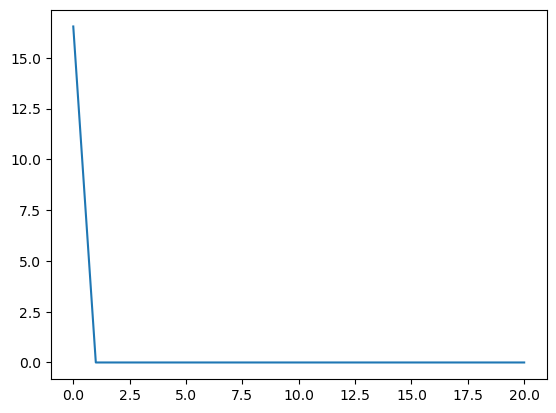

In [187]:
plt.plot(score_values)
# plt.plot(dff_2['MorbidityCount'])

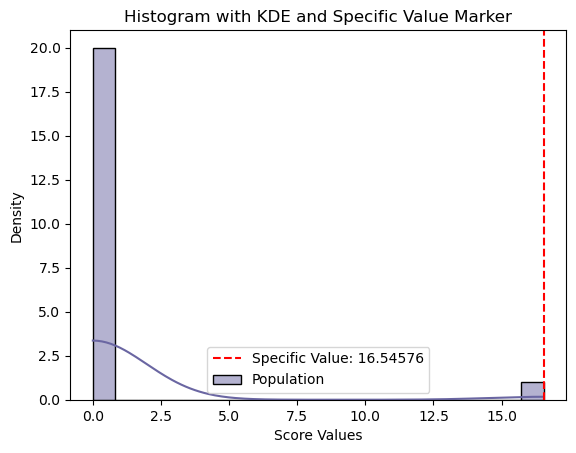

In [188]:
sns.histplot(score_values, bins=20, kde=True, color='#6A66A2', label='Population')

# Mark a specific value on the x-axis with a vertical line
specific_value = score_values[0]  # Change this to the desired value
plt.axvline(x=specific_value, color='red', linestyle='--', label=f'Specific Value: {specific_value}')

# Add labels and legend
plt.xlabel('Score Values')
plt.ylabel('Density')
plt.title('Histogram with KDE and Specific Value Marker')
plt.legend()

# Show the plot
plt.show()

In [158]:
randomized_counts = np.random.poisson(lambda_estimate, size=len(dff_2))
randomized_counts = np.minimum(np.maximum(randomized_counts, 0), 4)
        
dff_2['MorbidityCount1'] = randomized_counts
dff_2['expectationPoisson1'] = dff_2['MorbidityCount1'].mean()

# Perform the scan with the specified penalty value
subb, score = scanner.scan(dff_2[search_space1], dff_2['MorbidityCount1'], dff_2['expectationPoisson1'], cpu=0.95,
                                penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
subb,score

({'cholesterol_1_phase1': ['0.55 - 3.06',
   '3.06 - 3.43',
   '3.43 - 3.73',
   '3.73 - 3.98',
   '3.98 - 4.25',
   '4.25 - 4.55',
   '4.55 - 4.81'],
  'alcohol_use_status_c_phase1': [3],
  'hdl_phase1': ['1.08 - 1.17']},
 4.7253033174274535)

In [168]:
np.unique(np.random.poisson(lambda_estimate, size=len(dff_2)),return_counts=True)

(array([0, 1, 2, 3, 4]), array([1197,  579,  136,   23,    4]))

In [279]:
dff.egfr_c_phase1.max()

197.09

In [293]:
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Counts': disease_counts,
    'IDR': IDR_results,
    'Size (%)': size_percent,
    'Count (%)': counts_percent,
    'P value': p_values,
})

# Display the DataFrame
results_df

,Penalty,No of literals,Subset,Size,Counts,IDR,Size (%),Count (%),P value
0,0.05,7,cholesterol 1 phase1[0.3 - 4.86] AND egfr c ph...,159,50,0.398,11.40,4.54,1.966465e-10
1,0.10,7,cholesterol 1 phase1[0.3 - 4.86] AND egfr c ph...,159,50,0.398,11.40,4.54,1.966465e-10
2,0.20,7,waist circumference phase1[510.0 - 950.0] AND ...,357,157,0.557,25.59,14.26,7.120411e-12
3,0.50,5,egfr c phase1[72.28 - 163.56] AND diabetes his...,159,51,0.406,11.40,4.63,3.252928e-10
4,0.80,5,diabetes history phase1[0 OR 2] AND triglyceri...,181,62,0.434,12.97,5.63,1.608138e-10
5,1.00,6,age phase1[38.0 - 59.0] AND cholesterol 1 phas...,103,22,0.271,7.38,2.00,1.278472e-09
6,2.00,4,waist circumference phase1[510.0 - 950.0] AND ...,374,173,0.586,26.81,15.71,6.449570e-11
7,3.50,3,bmi c phase1[14.53 - 26.04] AND age phase1[38....,383,185,0.612,27.46,16.80,6.436068e-10
8,4.50,2,bmi c phase1[14.53 - 24.45] AND egfr c phase1[...,478,256,0.679,34.27,23.25,2.292273e-08
9,6.50,2,bmi c phase1[14.53 - 24.45] AND egfr c phase1[...,478,256,0.679,34.27,23.25,2.292273e-08


In [455]:
results_df.to_csv('Poisson_HIGH_MAIN_NAIROBI_v2.csv', index=False)

In [278]:
dff.iloc[dataframes['df_2.0'].index,:]

,age_phase1,sex,highest_level_of_education_phase1,partnership_status_c_phase1,ses_site_quintile_c_phase1,occupation_phase1,alcohol_use_status_c_phase1,smoking_status_c_phase1,diabetes_history_phase1,mvpa_c_phase1,...,friedewald_ldl_c_phase1,triglycerides_phase1,egfr_c_phase1,acr_c_phase1,diabetes_status_c_phase1,ckd_c_phase1,cvd_status_phase1,hypertension_status_c_phase1,MorbidityCount,expectationPoisson
1,56,0,1,2,4,4,0,0,1,1320.0,...,2.694545,0.65,101.49,0.319149,0,0.0,0.0,1,1,0.789247
3,45,0,3,1,5,2,0,0,0,180.0,...,2.310909,1.34,112.62,3.234694,0,1.0,0.0,0,1,0.789247
6,57,0,3,0,4,2,0,0,0,540.0,...,1.238182,0.95,101.48,0.364780,0,0.0,0.0,1,1,0.789247
7,51,1,0,1,4,4,0,0,0,0.0,...,2.362727,1.82,93.68,0.384868,0,0.0,0.0,1,1,0.789247
10,53,0,0,1,2,2,3,0,1,600.0,...,2.103636,1.62,93.52,0.933962,0,0.0,0.0,1,1,0.789247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376,50,0,1,2,2,4,1,0,0,2400.0,...,2.484545,0.98,81.84,0.906250,0,0.0,0.0,1,1,0.789247
1385,58,0,0,2,2,4,3,0,2,720.0,...,3.454545,0.87,107.37,0.187500,1,0.0,0.0,0,1,0.789247
1388,58,0,0,2,4,4,3,0,0,180.0,...,2.839091,0.64,98.48,1.031250,0,0.0,0.0,1,1,0.789247
1391,48,1,2,1,4,3,0,0,0,30.0,...,2.040000,0.55,86.25,0.612782,1,0.0,0.0,1,2,0.789247


### Utils
np.unique([dff.index.isin(dataframes['df_0.4'].index).astype(int)], return_counts=True)
dff.index.isin(dataframes['df_0.4'].index).astype(int)
boolmask = temp.index.isin(dataframes['df_0.5'].index).astype(int) == 0
temp[boolmask]#['triglycerides_phase1']

In [65]:
dff[(dff['age_phase1'] > 54) & (dff['age_phase1'] <= 67)]

,age_phase1,sex,highest_level_of_education_phase1,partnership_status_c_phase1,ses_site_quintile_c_phase1,occupation_phase1,alcohol_use_status_c_phase1,smoking_status_c_phase1,diabetes_history_phase1,mvpa_c_phase1,...,friedewald_ldl_c_phase1,triglycerides_phase1,egfr_c_phase1,acr_c_phase1,diabetes_status_c_phase1,ckd_c_phase1,cvd_status_phase1,hypertension_status_c_phase1,MorbidityCount,expectationPoisson
2,55,0,1,2,1,0,0,0,0,360.0,...,1.013636,0.74,109.22,0.405405,0,0.0,0.0,1,1,0.495616
6,59,1,1,1,4,3,1,0,0,1260.0,...,2.710000,1.21,98.35,0.491803,0,0.0,0.0,0,0,0.495616
21,59,1,1,1,3,3,1,1,0,2440.0,...,1.652727,0.61,103.95,1.198864,0,0.0,0.0,0,0,0.495616
23,60,0,1,0,1,3,3,0,0,900.0,...,2.764545,1.20,105.18,10.666667,0,1.0,0.0,1,2,0.495616
24,58,1,2,1,4,0,0,0,1,4740.0,...,1.460000,1.87,104.84,0.526316,0,0.0,0.0,0,0,0.495616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,58,1,1,1,4,0,0,0,0,6720.0,...,3.186364,2.01,73.20,1.165877,1,0.0,0.0,0,1,0.495616
1918,58,1,0,1,4,0,0,2,0,4200.0,...,4.053636,1.62,108.99,0.265487,0,0.0,0.0,0,0,0.495616
1919,55,0,1,1,2,3,0,0,1,780.0,...,3.081818,1.03,63.06,1.000000,0,0.0,0.0,1,1,0.495616
1927,57,1,2,2,5,0,0,0,0,2100.0,...,3.709091,1.41,99.27,0.769231,0,0.0,0.0,1,1,0.495616


In [333]:
dff[(dff['age_phase1'] > 50) & (dff['age_phase1'] <= 67) & (dff['waist_circumference_phase1'] > 894.89)]

,age_phase1,sex,highest_level_of_education_phase1,partnership_status_c_phase1,ses_site_quintile_c_phase1,occupation_phase1,alcohol_use_status_c_phase1,smoking_status_c_phase1,diabetes_history_phase1,mvpa_c_phase1,...,friedewald_ldl_c_phase1,triglycerides_phase1,egfr_c_phase1,acr_c_phase1,diabetes_status_c_phase1,ckd_c_phase1,cvd_status_phase1,hypertension_status_c_phase1,MorbidityCount,expectationPoisson
23,60,0,1,0,1,3,3,0,0,900.0,...,2.764545,1.20,105.18,10.666667,0,1.0,0.0,1,2,0.495616
24,58,1,2,1,4,0,0,0,1,4740.0,...,1.460000,1.87,104.84,0.526316,0,0.0,0.0,0,0,0.495616
25,56,0,2,2,5,0,0,0,1,90.0,...,2.370000,0.88,94.94,0.608247,1,0.0,0.0,0,1,0.495616
57,57,0,1,1,5,0,1,0,0,4620.0,...,2.009091,0.97,106.35,0.652174,0,0.0,0.0,1,1,0.495616
60,61,0,0,1,4,0,0,0,0,300.0,...,3.417273,2.25,77.76,4.887850,1,1.0,0.0,0,2,0.495616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918,58,1,0,1,4,0,0,2,0,4200.0,...,4.053636,1.62,108.99,0.265487,0,0.0,0.0,0,0,0.495616
1919,55,0,1,1,2,3,0,0,1,780.0,...,3.081818,1.03,63.06,1.000000,0,0.0,0.0,1,1,0.495616
1930,57,1,1,1,5,0,3,0,1,7140.0,...,3.662727,1.05,93.03,0.299771,0,0.0,0.0,0,0,0.495616
1936,54,0,2,1,5,0,0,0,0,120.0,...,3.043636,1.18,88.42,1.000000,1,0.0,0.0,0,1,0.495616


In [63]:
dff[(dff['age_phase1'] > 54) & (dff['age_phase1'] <= 67) & (dff['sex'] == 0)]

,age_phase1,sex,highest_level_of_education_phase1,partnership_status_c_phase1,ses_site_quintile_c_phase1,occupation_phase1,alcohol_use_status_c_phase1,smoking_status_c_phase1,diabetes_history_phase1,mvpa_c_phase1,...,friedewald_ldl_c_phase1,triglycerides_phase1,egfr_c_phase1,acr_c_phase1,diabetes_status_c_phase1,ckd_c_phase1,cvd_status_phase1,hypertension_status_c_phase1,MorbidityCount,expectationPoisson
2,55,0,1,2,1,0,0,0,0,360.0,...,1.013636,0.740000,109.22,0.405405,0,0.0,0.0,1,1,0.495616
23,60,0,1,0,1,3,3,0,0,900.0,...,2.764545,1.200000,105.18,10.666667,0,1.0,0.0,1,2,0.495616
25,56,0,2,2,5,0,0,0,1,90.0,...,2.370000,0.880000,94.94,0.608247,1,0.0,0.0,0,1,0.495616
44,56,0,2,1,3,3,3,0,0,1860.0,...,1.756364,0.470000,82.03,1.625850,0,0.0,0.0,0,0,0.495616
57,57,0,1,1,5,0,1,0,0,4620.0,...,2.009091,0.970000,106.35,0.652174,0,0.0,0.0,1,1,0.495616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1870,57,0,0,2,5,0,3,0,1,330.0,...,2.590769,9.964308,102.35,5.020134,1,1.0,0.0,1,3,0.495616
1881,59,0,2,2,3,3,0,0,0,420.0,...,2.649091,0.750000,92.70,1.738462,0,0.0,0.0,1,1,0.495616
1887,63,0,1,1,3,3,0,0,0,300.0,...,3.665455,1.330000,104.68,10.285714,1,1.0,0.0,1,3,0.495616
1888,56,0,1,1,1,4,0,0,1,630.0,...,3.712727,2.040000,100.37,2.456140,0,0.0,0.0,1,1,0.495616


In [366]:
dff[(dff['age_phase1'] > 50) & (dff['age_phase1'] <= 67) & (dff['sex'] == 0) & (dff['waist_hip_r_c_phase1'] > 0.87) & (dff['waist_hip_r_c_phase1'] <= 9.02)]

,age_phase1,sex,highest_level_of_education_phase1,partnership_status_c_phase1,ses_site_quintile_c_phase1,occupation_phase1,alcohol_use_status_c_phase1,smoking_status_c_phase1,diabetes_history_phase1,mvpa_c_phase1,...,friedewald_ldl_c_phase1,triglycerides_phase1,egfr_c_phase1,acr_c_phase1,diabetes_status_c_phase1,ckd_c_phase1,cvd_status_phase1,hypertension_status_c_phase1,MorbidityCount,expectationPoisson
23,60,0,1,0,1,3,3,0,0,900.0,...,2.764545,1.20,105.18,10.666667,0,1.0,0.0,1,2,0.495616
25,56,0,2,2,5,0,0,0,1,90.0,...,2.370000,0.88,94.94,0.608247,1,0.0,0.0,0,1,0.495616
44,56,0,2,1,3,3,3,0,0,1860.0,...,1.756364,0.47,82.03,1.625850,0,0.0,0.0,0,0,0.495616
57,57,0,1,1,5,0,1,0,0,4620.0,...,2.009091,0.97,106.35,0.652174,0,0.0,0.0,1,1,0.495616
60,61,0,0,1,4,0,0,0,0,300.0,...,3.417273,2.25,77.76,4.887850,1,1.0,0.0,0,2,0.495616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,51,0,1,1,3,3,0,0,0,1200.0,...,2.099091,0.75,108.92,0.416667,0,0.0,0.0,1,1,0.495616
1887,63,0,1,1,3,3,0,0,0,300.0,...,3.665455,1.33,104.68,10.285714,1,1.0,0.0,1,3,0.495616
1888,56,0,1,1,1,4,0,0,1,630.0,...,3.712727,2.04,100.37,2.456140,0,0.0,0.0,1,1,0.495616
1919,55,0,1,1,2,3,0,0,1,780.0,...,3.081818,1.03,63.06,1.000000,0,0.0,0.0,1,1,0.495616


In [325]:
dff[(dff['age_phase1'] > 50) & (dff['age_phase1'] <= 67) & (dff['sex'] == 0) & (dff['waist_hip_r_c_phase1'] > 0.87) & (dff['waist_hip_r_c_phase1'] <= 9.02) & (dff['bmi_c_phase1'] > 18.95) & (dff['bmi_c_phase1'] <= 62.8)]

,age_phase1,sex,highest_level_of_education_phase1,partnership_status_c_phase1,ses_site_quintile_c_phase1,occupation_phase1,alcohol_use_status_c_phase1,smoking_status_c_phase1,diabetes_history_phase1,mvpa_c_phase1,...,friedewald_ldl_c_phase1,triglycerides_phase1,egfr_c_phase1,acr_c_phase1,diabetes_status_c_phase1,ckd_c_phase1,cvd_status_phase1,hypertension_status_c_phase1,MorbidityCount,expectationPoisson
23,60,0,1,0,1,3,3,0,0,900.0,...,2.764545,1.20,105.18,10.666667,0,1.0,0.0,1,2,0.495616
25,56,0,2,2,5,0,0,0,1,90.0,...,2.370000,0.88,94.94,0.608247,1,0.0,0.0,0,1,0.495616
57,57,0,1,1,5,0,1,0,0,4620.0,...,2.009091,0.97,106.35,0.652174,0,0.0,0.0,1,1,0.495616
60,61,0,0,1,4,0,0,0,0,300.0,...,3.417273,2.25,77.76,4.887850,1,1.0,0.0,0,2,0.495616
86,53,0,1,2,5,0,3,2,0,2520.0,...,4.510909,1.12,92.34,0.523364,1,0.0,0.0,1,2,0.495616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,51,0,1,1,3,3,0,0,0,1200.0,...,2.099091,0.75,108.92,0.416667,0,0.0,0.0,1,1,0.495616
1887,63,0,1,1,3,3,0,0,0,300.0,...,3.665455,1.33,104.68,10.285714,1,1.0,0.0,1,3,0.495616
1888,56,0,1,1,1,4,0,0,1,630.0,...,3.712727,2.04,100.37,2.456140,0,0.0,0.0,1,1,0.495616
1919,55,0,1,1,2,3,0,0,1,780.0,...,3.081818,1.03,63.06,1.000000,0,0.0,0.0,1,1,0.495616


In [368]:
dff.bmi_c_phase1.max()

68.02

In [335]:
temp = dff[(dff['age_phase1'] >= 45) & (dff['waist_circumference_phase1'] > 950) & (dff['waist_circumference_phase1'] <= 1470)& (dff['triglycerides_phase1'] > 0.46)& (dff['triglycerides_phase1'] <= 5.34)]['MorbidityCount']
# temp = dff[(dff['age_phase1'] > 53) & (dff['bmi_c_phase1'] > 22.99)& (dff['bmi_c_phase1'] <= 68.02)& (dff['triglycerides_phase1'] > 0.46)& (dff['triglycerides_phase1'] <= 5.34)]['MorbidityCount']
# temp = dff[(dff['age_phase1'] > 53) & (dff['bmi_c_phase1'] > 21.46)& (dff['bmi_c_phase1'] <= 68.02)& (dff['triglycerides_phase1'] > 0.46)& (dff['triglycerides_phase1'] <= 5.34) & (dff['waist_hip_r_c_phase1'] > 0.9)& (dff['waist_hip_r_c_phase1'] <= 1.16)]['MorbidityCount']
# temp = dff[(dff['egfr_c_phase1'] >= 4.18) & (dff['egfr_c_phase1'] <= 72.28)]['MorbidityCount']
total_events_subset = temp.sum()
total_events = dff['MorbidityCount'].sum()

# Calculate incidence density
incidence_density_subset = total_events_subset / len(temp)
incidence_density = total_events / len(dff)

#Calc IDR
IDR = incidence_density_subset/incidence_density
print('IDR: ',np.round(IDR,3))
print('Pop size: ',len(dff), 'Pop counts: ', dff['MorbidityCount'].sum())
print('Subset size: ',len(temp), 'Subset counts: ', temp.sum())
print('Sub RR: ',np.round(temp.mean(),3), 'Pop RR: ', np.round(dff['MorbidityCount'].mean(),3))


IDR:  1.507
Pop size:  1939 Pop counts:  961
Subset size:  383 Subset counts:  286
Sub RR:  0.747 Pop RR:  0.496


In [382]:
# temp = dff[(dff['age_phase1'] > 50) & (dff['age_phase1'] <= 67) & (dff['sex'] == 0) & (dff['waist_hip_r_c_phase1'] > 0.87) & (dff['waist_hip_r_c_phase1'] <= 9.02) & (dff['bmi_c_phase1'] > 18.95) & (dff['bmi_c_phase1'] <= 62.8)]['MorbidityCount']
# temp = dff[(dff['age_phase1'] > 50) & (dff['age_phase1'] <= 67) & (dff['sex'] == 0) & (dff['waist_hip_r_c_phase1'] > 0.87) & (dff['waist_hip_r_c_phase1'] <= 9.02)]['MorbidityCount']
# temp = dff[(dff['age_phase1'] > 54) & (dff['age_phase1'] <= 67) & (dff['sex'] == 0)]['MorbidityCount']
temp = dff[(dff['age_phase1'] > 50) & (dff['age_phase1'] <= 67) & (dff['waist_circumference_phase1'] > 894.89)]['MorbidityCount']
# temp = dff[(dff['age_phase1'] > 54) & (dff['age_phase1'] <= 67)]['MorbidityCount']
total_events_subset = temp.sum()
total_events = dff['MorbidityCount'].sum()

# Calculate incidence density
incidence_density_subset = total_events_subset / len(temp)
incidence_density = total_events / len(dff)

#Calc IDR
IDR = incidence_density_subset/incidence_density
print('IDR: ',np.round(IDR,3))
print('Pop size: ',len(dff), 'Pop counts: ', dff['MorbidityCount'].sum())
print('Subset size: ',len(temp), 'Subset counts: ', temp.sum())
print('Sub RR: ',np.round(temp.mean(),3), 'Pop RR: ', np.round(dff['MorbidityCount'].mean(),3))

IDR:  1.347
Pop size:  1395 Pop counts:  1101
Subset size:  444 Subset counts:  472
Sub RR:  1.063 Pop RR:  0.789


In [383]:
# Calculate Log-IDR and its standard error
log_IDR = np.log(IDR)
SE_log_IDR = np.sqrt((1/total_events_subset) + (1/total_events))

# Calculate 95% Confidence Interval for Log-IDR
CI_lower_log = log_IDR - 1.96 * SE_log_IDR
CI_upper_log = log_IDR + 1.96 * SE_log_IDR

# Transform the CI back to the original scale
CI_lower = np.exp(CI_lower_log)
CI_upper = np.exp(CI_upper_log)

# Z-test for significance
Z_score = log_IDR / SE_log_IDR
# Two-tail test
p_value = stats.norm.sf(abs(Z_score)) * 2 

print("Log-IDR: {:.3f}".format(log_IDR))
print("95% Confidence Interval: [{:.3f}, {:.3f}]".format(CI_lower, CI_upper))
print("Z-score: {:.3f}".format(Z_score))
print("p-value: {:.2e}".format(p_value))

Log-IDR: 0.298
95% Confidence Interval: [1.209, 1.500]
Z-score: 5.413
p-value: 6.18e-08


### Agincourt (0.79)
- 4 lit:: 1.568; [1.383, 1.779]; Log-IDR: 0.450; Z-score: 7.020; Mean: 1.24
- 3 lit:: 1.441; [1.288, 1.612]; Log-IDR: 0.365; Z-score: 6.384; Mean: 1.14
- 1 lit:: 1.710; [1.466, 1.996]; Log-IDR: 0.537; Z-score: 6.818; Mean: 1.35
- 3 lit:: 1.431, [1.286, 1.593]; Log-IDR: 0.358; Z-score: 6.552; Mean: 1.13
### Transfered to Nairobi (0.50)
- 4 lit:: 1.806; [1.535, 2.126]; Log-IDR: 0.591; Z-score: 7.125; Mean: 0.90
- 3 lit:: 1.722; [1.487, 1.993]; Log-IDR: 0.543; Z-score: 7.282; Mean: 0.85
- 1 lit:: 1.731; [1.449, 2.068]; Log-IDR: 0.549; Z-score: 6.048; Mean: 0.86
- 3 lit:: 1.506; [1.320, 1.719]; Log-IDR: 0.410; Z-score: 6.086; Mean: 0.75


### Nairobi (0.50)
- 4 lit:: 1.975; [1.711, 2.280]; Log-IDR: 0.681; Z-score: 9.305; Mean: 0.98
- 3 lit:: 1.935; [1.678, 2.232]; Log-IDR: 0.660; Z-score: 9.073; Mean: 0.96
- 2 lit:: 1.921; [1.638, 2.253]; Log-IDR: 0.653; Z-score: 8.020; Mean: 0.95
- 1 lit:: 1.554; [1.362, 1.774]; Log-IDR: 0.441; Z-score: 6.537; Mean: 0.77
### Transferred to Agincourt (0.79)
- 4 lit:: 1.335; [1.181, 1.510]; Log-IDR: 0.289; Z-score: 4.617; Mean: 1.05
- 3 lit:: 1.342; [1.188, 1.517]; Log-IDR: 0.295; Z-score: 4.736; Mean: 1.06
- 2 lit:: 1.345; [1.179, 1.535]; Log-IDR: 0.296; Z-score: 4.403; Mean: 1.06
- 1 lit:: 1.287; [1.145, 1.427]; Log-IDR: 0.246; Z-score: 4.371; Mean: 1.01

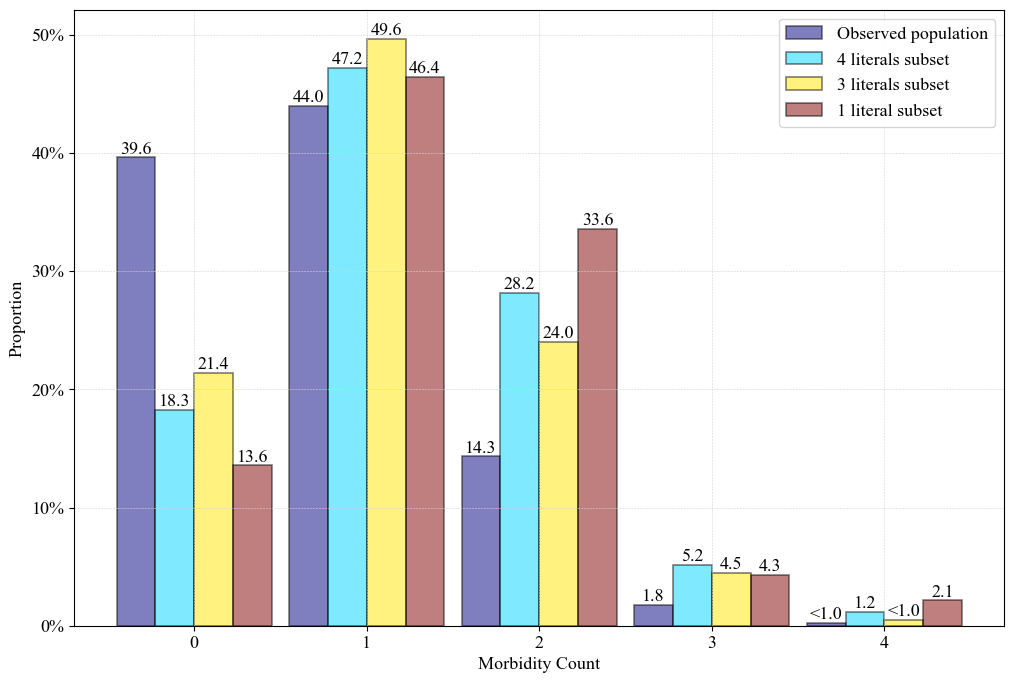

In [464]:
plt.figure(figsize=(12,8))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 13
cmap = plt.cm.get_cmap('jet', 4)  # '4' to create four distinct colors
# Create a grouped histogram
bins = np.arange(6) - 0.5 # Defining bins edges so that integers are centered
n, bins, patches = plt.hist([dff.MorbidityCount, dataframes['df_0.5'].MorbidityCount, dataframes['df_2.0'].MorbidityCount, dataframes['df_3.5'].MorbidityCount], bins=bins, alpha=0.5, label=['Observed population', '4 literals subset', '3 literals subset', '1 literal subset'], color=[cmap(i) for i in range(4)], edgecolor='black', linewidth=1.2, density=True, rwidth=0.9)
# n, bins, patches = plt.hist([dff.MorbidityCount, dataframes['df_4.5'].MorbidityCount, dataframes['df_5.5'].MorbidityCount, dataframes['df_7.5'].MorbidityCount], bins=bins, alpha=0.5, label=['Observed population', '3 literals subset', '2 literals subset', '1 literal subset'], color=[cmap(i) for i in range(4)], edgecolor='black', linewidth=1.2, density=True, rwidth=0.9)
# color=['#DEEFB7', 'salmon', 'orange', 'red']
# Calculating the width of each bin to properly align text labels
bin_width = np.diff(bins)[0]
bar_width = bin_width * 0.9 / 4  # Assuming rwidth=0.9 and 3(4) groups

# Adding density values above each bar, adjusting alignment
for i in range(len(n)):  # Loop over each group
    for j in range(len(n[i])):  # Loop over each bin in the group
        # Calculate the center of each bar
        bar_center = bins[j] + bin_width/2 + (i - 1.5) * bar_width
        if n[i][j] >= 0.01:  # Only add text if the bar is visible
            plt.text(bar_center, n[i][j], f'{n[i][j]*100:.1f}', ha='center', va='bottom')
        elif n[i][j] < 0.01:
            plt.text(bar_center, n[i][j], '<1.0', ha='center', va='bottom')
plt.xlabel('Morbidity Count')
plt.ylabel('Proportion')
# plt.title('Grouped Histogram of Morbidity Count by Subset')
plt.xticks(ticks=np.arange(5), labels=['0', '1', '2', '3', '4'])  # Setting custom x-ticks to align with the morbidity counts
# plt.xlim(-0.5, 4.5) 
# Turning off y-axis ticks and labels
plt.yticks(ticks=np.arange(0.0,0.6,0.1), labels=['0%', '10%', '20%', '30%', '40%', '50%'])
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.4)
plt.legend()
plt.show()

/var/folders/v6/43nstwv52771z0q7sjpfqzv00000gn/T/ipykernel_76305/3503965817.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 3)  # '3' for three other groups since we don't plot the first group
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


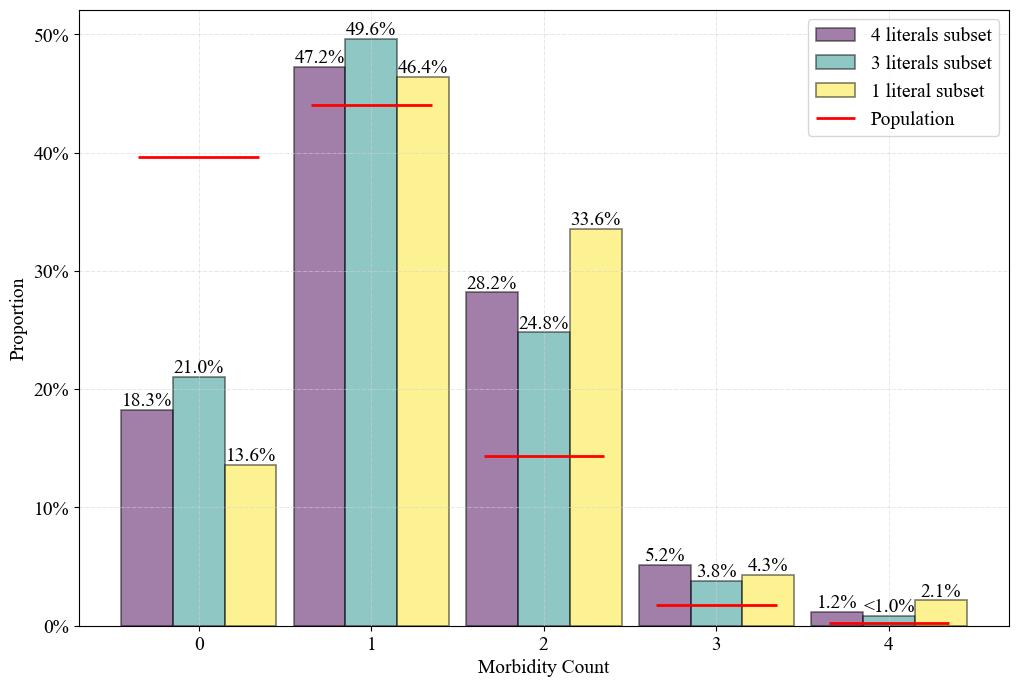

In [299]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
cmap = plt.cm.get_cmap('viridis', 3)  # '3' for three other groups since we don't plot the first group

# Define bins and calculate histogram data
bins = np.arange(6) - 0.5  # Defining bins edges so that integers are centered

# Hist data excluding the first group which is used for reference lines
# hist_data = [dataframes['df_0.5'].MorbidityCount, dataframes['df_2.0'].MorbidityCount, dataframes['df_3.5'].MorbidityCount]
# labels = ['3 literals subset', '2 literals subset', '1 literal subset']
hist_data = [dataframes['df_0.5'].MorbidityCount, dataframes['df_1.0'].MorbidityCount, dataframes['df_3.5'].MorbidityCount]
labels = ['4 literals subset', '3 literals subset', '1 literal subset']

# Get counts for the reference data separately
ref_counts, _ = np.histogram(dff.MorbidityCount, bins=bins, density=True)

# Plot histograms for other groups
n, bins, patches = plt.hist(hist_data, bins=bins, alpha=0.5, label=labels, color=[cmap(i) for i in range(len(hist_data))], edgecolor='black', linewidth=1.2, density=True, rwidth=0.9)

# Calculate the center of each bin for placing the reference lines correctly
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_width = np.diff(bins)[0]
rwidth = 0.9  # relative width of bars
group_width = bin_width * rwidth / len(hist_data)  # width of groups

for i, density in enumerate(ref_counts):
    if i == 0:
        # Only add a label to the first line
        plt.hlines(density, bin_centers[i] - 0.5 * bin_width + 0.5 * group_width,
                   bin_centers[i] + 0.5 * bin_width - 0.5 * group_width,
                   colors='red', linewidth=2.0, label='Population')
    else:
        # Do not add a label to the rest of the lines
        plt.hlines(density, bin_centers[i] - 0.5 * bin_width + 0.5 * group_width,
                   bin_centers[i] + 0.5 * bin_width - 0.5 * group_width,
                   colors='red',linewidth=2.0)

# Adding text annotations for densities
for i, patch_set in enumerate(patches):
    for rect, ni in zip(patch_set.patches, n[i]):
        height = ni
        if height >= 0.01:  # Only annotate if visible
            plt.text(rect.get_x() + rect.get_width() / 2, height, f'{height*100:.1f}%', ha='center', va='bottom')
        elif height > 0:
            plt.text(rect.get_x() + rect.get_width() / 2, height, '<1.0%', ha='center', va='bottom')
label=['Population']
plt.xlabel('Morbidity Count')
plt.ylabel('Proportion')
plt.xticks(ticks=np.arange(5), labels=['0', '1', '2', '3', '4'])  # Custom x-ticks to align with morbidity counts
plt.yticks(ticks=np.arange(0.0, 0.6, 0.1), labels=['0%', '10%', '20%', '30%', '40%', '50%'])
plt.grid(color='lightgray', linestyle='-.', linewidth=0.4)
plt.legend()
# Save the figure as .eps
fig.savefig("/Users/kayadetunji/Downloads/figs/subsets_ag.eps", format='eps')

# Save the figure as a vector-based PDF
fig.savefig("/Users/kayadetunji/Downloads/figs/subsets_ag.pdf", format='pdf')
plt.show()


/var/folders/v6/43nstwv52771z0q7sjpfqzv00000gn/T/ipykernel_12874/4181889838.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 3)  # '4' to create four distinct colors


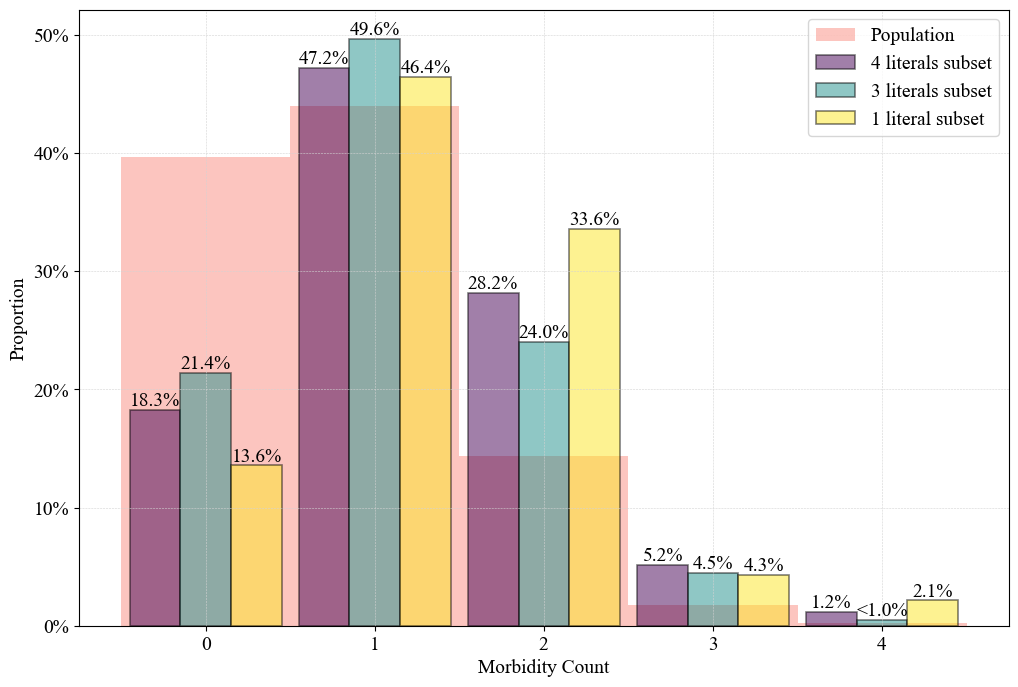

In [24]:

plt.figure(figsize=(12,8))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
cmap = plt.cm.get_cmap('viridis', 3)  # '4' to create four distinct colors
# Create a grouped histogram
bins = np.arange(6) - 0.5 # Defining bins edges so that integers are centered
plt.hist(dff.MorbidityCount, bins=np.arange(-0.5, max(dff.MorbidityCount) + 1.5, 1), density=True, alpha=0.45, color='salmon', label='Population')
n, bins, patches = plt.hist([dataframes['df_0.5'].MorbidityCount, dataframes['df_2.0'].MorbidityCount, dataframes['df_3.5'].MorbidityCount], bins=bins, alpha=0.5, label=['4 literals subset', '3 literals subset', '1 literal subset'], color=[cmap(i) for i in range(3)], edgecolor='black', linewidth=1.2, density=True, rwidth=0.9)
# n, bins, patches = plt.hist([dataframes['df_4.5'].MorbidityCount, dataframes['df_5.5'].MorbidityCount, dataframes['df_7.5'].MorbidityCount], bins=bins, alpha=0.5, label=['3 literals subset', '2 literals subset', '1 literal subset'], color=[cmap(i) for i in range(3)], edgecolor='black', linewidth=1.2, density=True, rwidth=0.9)
# color=['#DEEFB7', 'salmon', 'orange', 'red']
# Calculating the width of each bin to properly align text labels
bin_width = np.diff(bins)[0]
bar_width = bin_width * 0.9 / 3  # Assuming rwidth=0.9 and 3(4) groups

# Adding density values above each bar, adjusting alignment
for i in range(len(n)):  # Loop over each group
    for j in range(len(n[i])):  # Loop over each bin in the group
        # Calculate the center of each bar
        bar_center = bins[j] + bin_width/2 + (i - 1.0) * bar_width
        if n[i][j] >= 0.01:  # Only add text if the bar is visible
            plt.text(bar_center, n[i][j], f'{n[i][j]*100:.1f}%', ha='center', va='bottom')
        elif n[i][j] < 0.01:
            plt.text(bar_center, n[i][j], '<1.0%', ha='center', va='bottom')
plt.xlabel('Morbidity Count')
plt.ylabel('Proportion')
# plt.title('Grouped Histogram of Morbidity Count by Subset')
plt.xticks(ticks=np.arange(5), labels=['0', '1', '2', '3', '4'])  # Setting custom x-ticks to align with the morbidity counts
# plt.xlim(-0.5, 4.5) 
# Turning off y-axis ticks and labels
plt.yticks(ticks=np.arange(0.0,0.6,0.1), labels=['0%', '10%', '20%', '30%', '40%', '50%'])
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.4)
plt.legend()
plt.show()

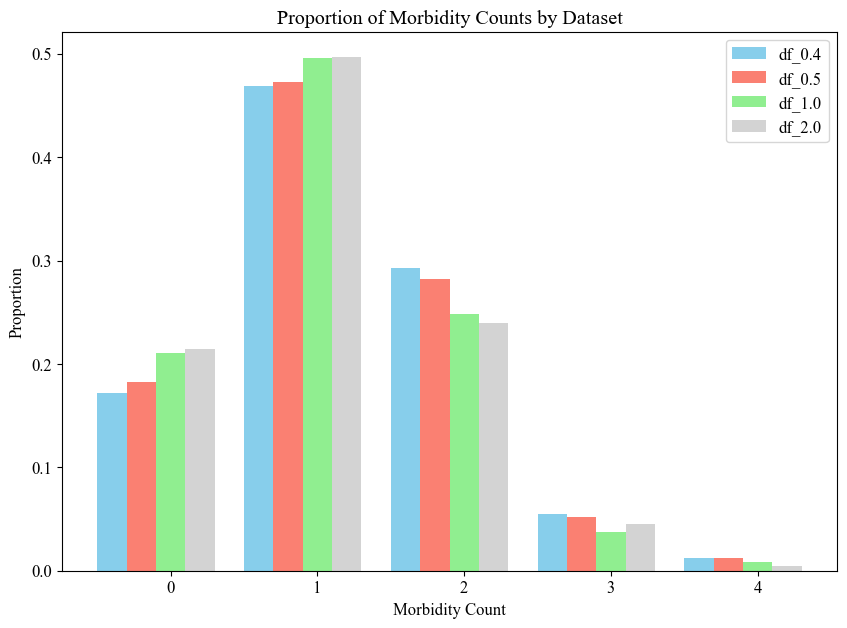

In [164]:
# Re-defining the datasets
# dff = pd.DataFrame({'MorbidityCount': [0, 1, 2, 3, 4, 1, 2, 3, 0, 4]})
# dataframes = {
#     'pop': dff,
#     'df_0.5': pd.DataFrame({'MorbidityCount': np.random.choice([0, 1, 2, 3, 4], size=10, p=[0.2, 0.2, 0.2, 0.2, 0.2])}),
#     'df_2.0': pd.DataFrame({'MorbidityCount': np.random.choice([0, 1, 2, 3, 4], size=10, p=[0.2, 0.2, 0.2, 0.2, 0.2])}),
#     'df_3.0': pd.DataFrame({'MorbidityCount': np.random.choice([0, 1, 2, 3, 4], size=10, p=[0.2, 0.2, 0.2, 0.2, 0.2])})
# }

# Calculating proportions for each dataset
proportions = {}
for key, df in dataframes.items():
    count = df['MorbidityCount'].value_counts(normalize=True).sort_index()
    proportions[key] = count

# Converting proportions to a DataFrame for easier plotting
proportions_df = pd.DataFrame(proportions).fillna(0)  # Fill missing values with 0 to ensure all morbidity counts are represented

# Plot setup
fig, ax = plt.subplots(figsize=(10, 7))
bar_width = 0.2  # Bar width
indexes = np.arange(len(proportions_df))  # Morbidity count indexes

# Colors for the bars
colors = ['skyblue', 'salmon', 'lightgreen', 'lightgrey']

# Plotting each dataset as a separate bar group with proportions
for i, (key, color) in enumerate(zip(proportions_df.columns, colors)):
    ax.bar(indexes + i*bar_width, proportions_df[key], bar_width, label=key, color=color)

# Labeling the axes and setting the title
ax.set_xlabel('Morbidity Count', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)
ax.set_title('Proportion of Morbidity Counts by Dataset')
ax.set_xticks(indexes + bar_width*len(proportions_df.columns)/2 - bar_width/2)
ax.set_xticklabels(proportions_df.index)

# Adding a legend
ax.legend()

plt.show()


In [173]:
proportions_df.loc[morbidity_count,['Population','df_0.5', 'df_1.0', 'df_2.0', 'df_3.5']]

Population    0.002151
df_0.5        0.011905
df_1.0        0.008086
df_2.0        0.004706
df_3.5        0.021429
Name: 4, dtype: float64

In [172]:
positions[0:]

array([0.3, 1.3, 2.3, 3.3, 4.3, 5.3])

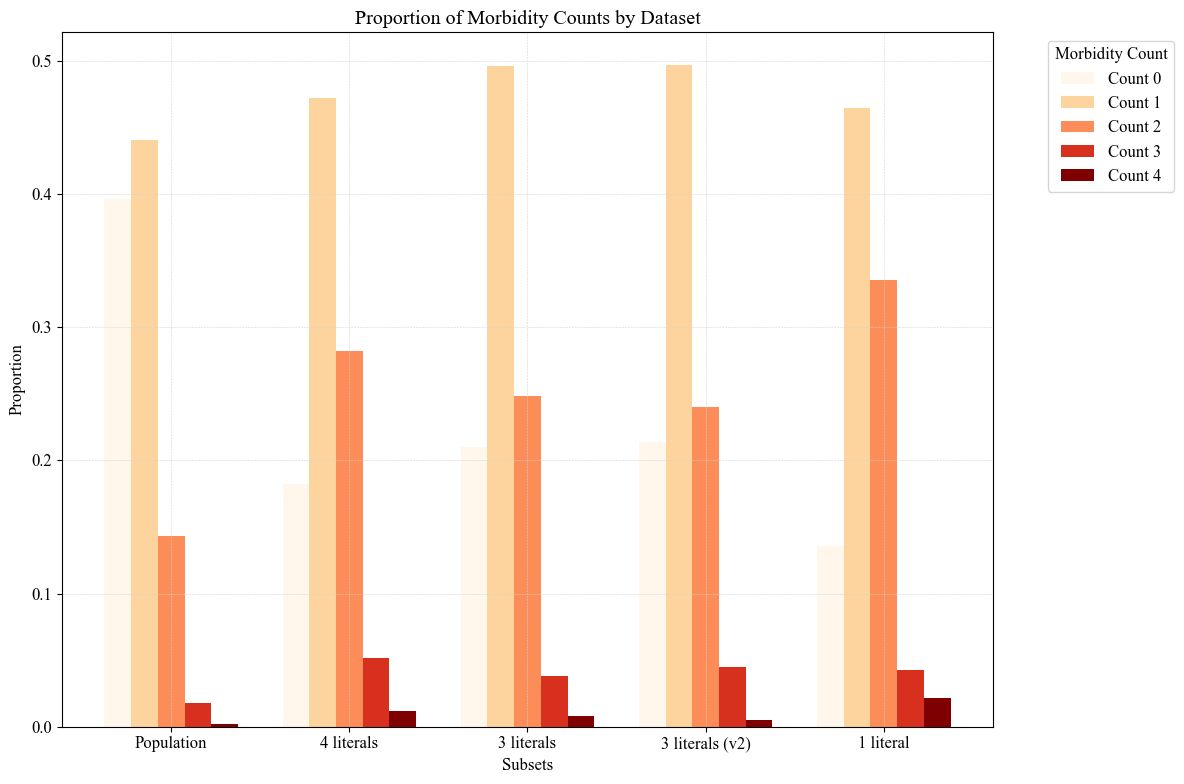

In [187]:
# Correcting the plot with a dynamic approach to assign colors and ensuring there's a color for each morbidity count
# Generating a list of colors based on the number of morbidity counts to avoid index out of range errors
color_map = plt.cm.get_cmap('OrRd', len(proportions_df.index))

# Adjusting the plot setup to ensure correct alignment and representation
fig, ax = plt.subplots(figsize=(12, 8))
dataset_positions = np.arange(len(proportions_df.columns))  # Dataset positions on the x-axis
bar_width = 0.15  # Narrower bar width to fit all counts
proportions_df['Population'] = dff['MorbidityCount'].value_counts(normalize=True).sort_index()
# Plotting each morbidity count as a separate bar for each dataset

for i, morbidity_count in enumerate(proportions_df.index):
    positions = dataset_positions + (i - len(proportions_df.index)/2)*bar_width + bar_width/2
    ax.bar(positions[1:], proportions_df.loc[morbidity_count,['Population','df_0.5', 'df_1.0', 'df_2.0', 'df_3.5']], bar_width, label=f'Count {morbidity_count}', color=color_map(i))

# Adding chart details
ax.set_xlabel('Subsets', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)
ax.set_title('Proportion of Morbidity Counts by Dataset')
ax.set_xticks(dataset_positions[1:])
# ax.set_xticklabels(proportions_df.loc[:,['Population','df_0.5', 'df_1.0', 'df_2.0', 'df_3.5']].columns)
ax.set_xticklabels(['Population', '4 literals', '3 literals', '3 literals (v2)', '1 literal'])

plt.legend(title='Morbidity Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.4)
plt.tight_layout()
plt.show()


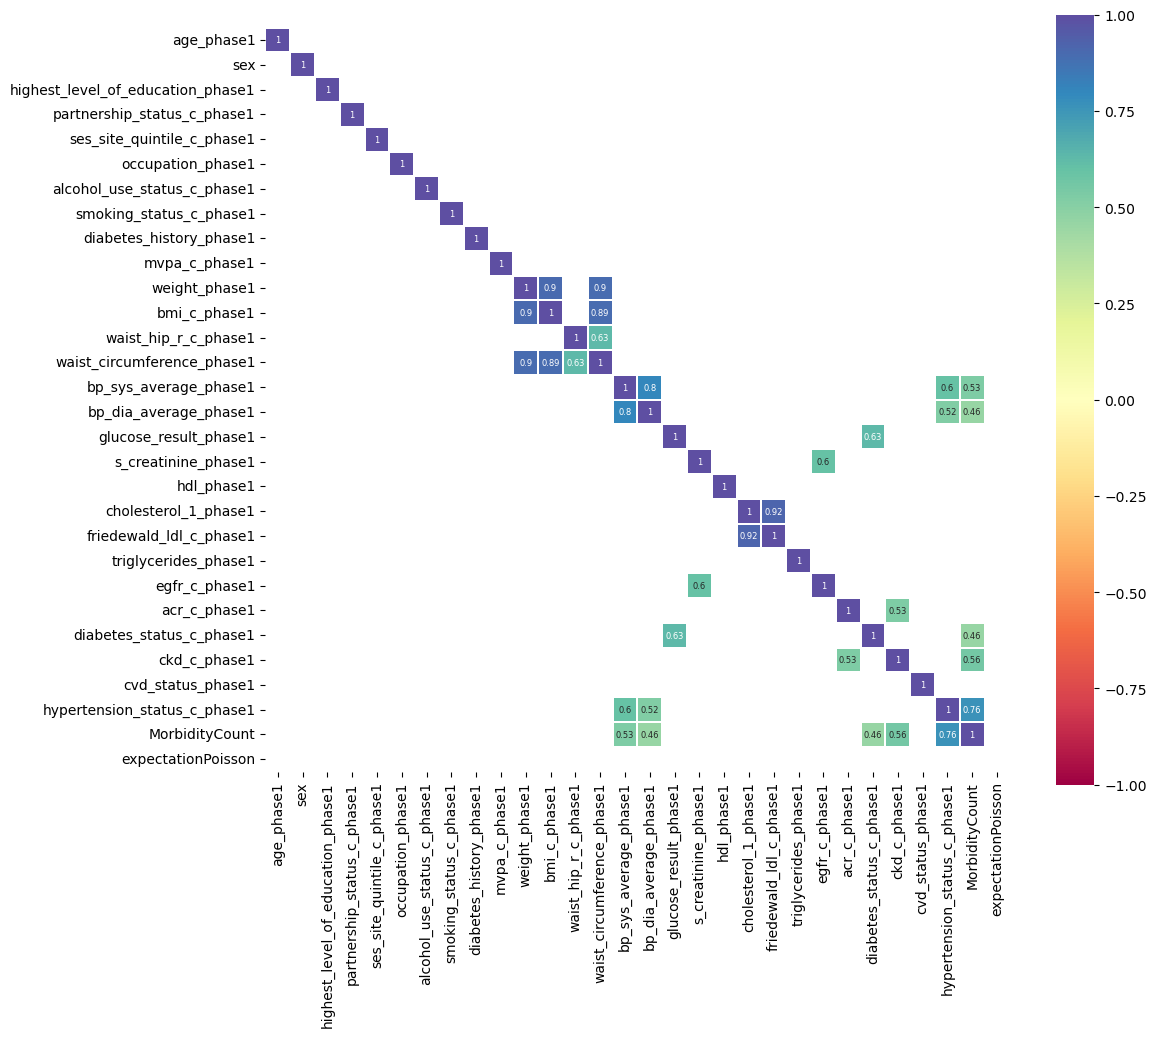

In [338]:
import seaborn as sns
correlation_matrix = dff.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.75)]


plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix[(correlation_matrix >= 0.4) | (correlation_matrix <= -0.4)], 
            cmap='Spectral', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 6}, square=True);

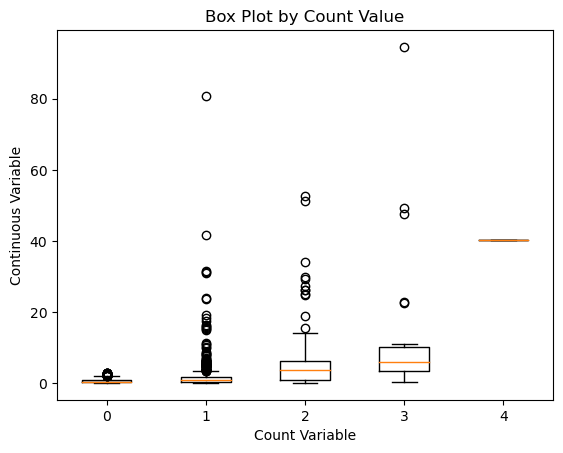

In [132]:
plt.boxplot([dff['acr_c_phase1'][dff['MorbidityCount'] == i] for i in np.unique(dff['MorbidityCount'])])
plt.xticks(ticks=np.arange(1, len(np.unique(dff['MorbidityCount'])) + 1), labels=np.unique(dff['MorbidityCount']))
plt.xlabel('Count Variable')
plt.ylabel('Continuous Variable')
plt.title('Box Plot by Count Value')
plt.show()


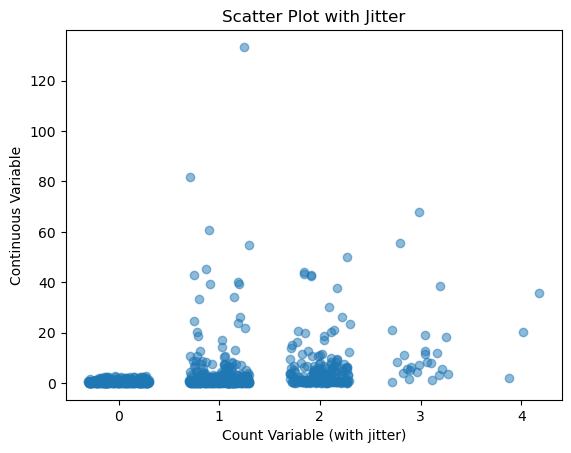

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming continuous_var and count_var are your variables
# Add jitter to the count variable for visibility
count_var_jittered = dff['MorbidityCount'] + np.random.uniform(-0.3, 0.3, size=len(dff['MorbidityCount']))

plt.scatter(count_var_jittered, dff['acr_c_phase1'], alpha=0.5)
plt.xlabel('Count Variable (with jitter)')
plt.ylabel('Continuous Variable')
plt.title('Scatter Plot with Jitter')
plt.show()


In [ ]:
plt.boxplot([dff['acr_c_phase1'][dff['MorbidityCount'] == i] for i in np.unique(dff['MorbidityCount'])])
plt.xticks(ticks=np.arange(1, len(np.unique(dff['MorbidityCount'])) + 1), labels=np.unique(dff['MorbidityCount']))
plt.xlabel('Count Variable')
plt.ylabel('Continuous Variable')
plt.title('Box Plot by Count Value')
plt.show()
import seaborn as sns
df = pd.concat([dataframes['df_0.3'], dataframes['df_0.8']], dataframes['df_1.0'], ignore_index=True)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for BMI across subsets
sns.boxplot(x='Subset', y='BMI', data=df, ax=axs[0])
axs[0].set_title('BMI Distribution across Subsets')

# Scatterplot for Age vs. BMI, colored by Subset
sns.scatterplot(x='age_phase1', y='bmi_c_phase1', hue='Subset', data=df, ax=axs[1], palette='bright')
axs[1].set_title('Age vs. BMI by Subset')

plt.tight_layout()
plt.show()

In [289]:
from scipy.stats import mannwhitneyu, entropy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


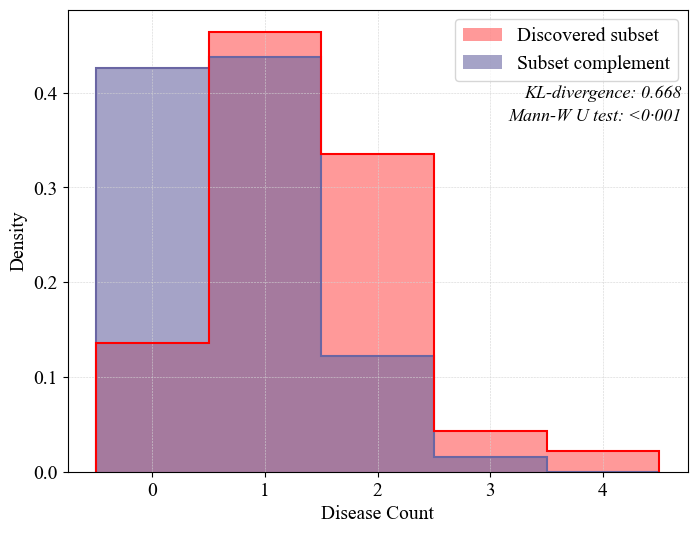

In [322]:
# Assuming poisData and dataframes are defined and available
x = np.arange(0, max(poisData) + 1)

subset = dataframes['df_3.5'].MorbidityCount
complement = dataframes_complement['df_3.5'].MorbidityCount

u_stat, p_value = mannwhitneyu(subset, complement)
values, base = np.histogram(np.hstack((subset, complement)), bins=40)
cumulative_subset = np.histogram(subset, bins=base, density=True)[0] * np.diff(base)
cumulative_complement = np.histogram(complement, bins=base, density=True)[0] * np.diff(base)

# Making sure there are no zeros to avoid division by zero in KL calculation
cumulative_subset += 1e-10
cumulative_complement += 1e-10

kl_divergence = entropy(cumulative_subset, cumulative_complement)

fig=plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
# First plot the filled histograms
# plt.hist(poisData, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.8, color='#DEEFB7', label='Observed Data')
plt.hist(subset, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.4, color='red', label='Discovered subset')
plt.hist(complement, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.6, color='#6A66A2', label='Subset complement')

# Then overlay with the step histograms for outlines
# plt.hist(poisData, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='lightblue', histtype='step', linewidth=2.5, edgecolor='#5AFF15')
plt.hist(complement, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='#721121', histtype='step', linewidth=1.5, edgecolor='#6A66A3')
plt.hist(subset, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='red', histtype='step', linewidth=1.5, edgecolor='red')

# plt.title('Histograms of Observed and Data Subsets')
plt.xlabel('Disease Count')
plt.ylabel('Density')
plt.xticks(x)
plt.legend()
ax.text(0.99, 0.75, f"Mann-W U test: <0·001" ,verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,fontsize=13, fontstyle='italic')
ax.text(0.99, 0.8, f"KL-divergence: {kl_divergence:.3f}",verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,fontsize=13, fontstyle='italic')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.4)

fig.savefig("/Users/kayadetunji/Downloads/figs/complement_pos_35_ag.eps", format='eps')
fig.savefig("/Users/kayadetunji/Downloads/figs/complement_pos_35_ag.pdf", format='pdf')
plt.show()

In [244]:
import numpy as np
from scipy.stats import mannwhitneyu, entropy
from scipy.special import kl_div

# Example data similar to your description
subset = dataframes['df_1.0'].MorbidityCount
complement = dataframes_complement['df_1.0'].MorbidityCount

# Mann-Whitney U test
u_stat, p_value = mannwhitneyu(subset, complement)
print(f"Mann-Whitney U Statistic: {u_stat}, P-value: {p_value}")

# KL Divergence
# First, we need to estimate the probability distributions. Let's use histograms.
values, base = np.histogram(np.hstack((subset, complement)), bins=40)
cumulative_subset = np.histogram(subset, bins=base, density=True)[0] * np.diff(base)
cumulative_complement = np.histogram(complement, bins=base, density=True)[0] * np.diff(base)

# Making sure there are no zeros to avoid division by zero in KL calculation
cumulative_subset += 1e-10
cumulative_complement += 1e-10

kl_divergence = entropy(cumulative_subset, cumulative_complement)
print(f"KL Divergence: {kl_divergence}")


Mann-Whitney U Statistic: 317503.5, P-value: 9.46515088179205e-22
KL Divergence: 0.1237619134404629


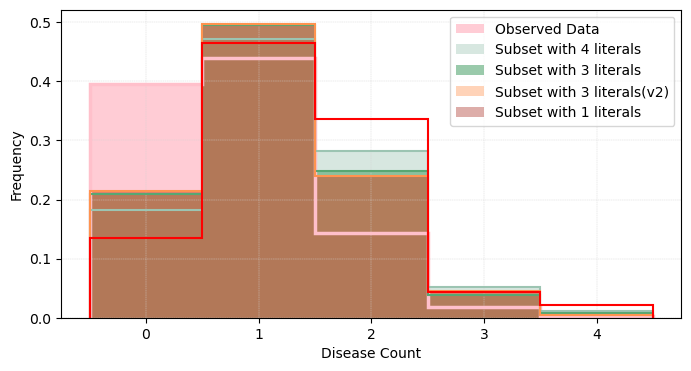

In [159]:
# Assuming poisData and dataframes are defined and available
x = np.arange(0, max(poisData) + 1)

plt.figure(figsize=(8, 4))
# First plot the filled histograms
plt.hist(poisData, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.8, color='pink', label='Observed Data')
# plt.hist(dataframes['df_0.4'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.6, color='#C2948A', label='Subset with 8 literals')
plt.hist(dataframes['df_0.5'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.4, color='#9CC4B2', label='Subset with 4 literals')
plt.hist(dataframes['df_1.0'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.6, color='#57A773', label='Subset with 3 literals')
plt.hist(dataframes['df_2.0'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.4, color='#FF934F', label='Subset with 3 literals(v2)')
plt.hist(dataframes['df_2.0'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.4, color='#AB3428', label='Subset with 1 literals')

# Then overlay with the step histograms for outlines
plt.hist(poisData, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='lightblue', histtype='step', linewidth=2.5, edgecolor='pink')
# plt.hist(dataframes['df_0.4'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='#721121', histtype='step', linewidth=1.5, edgecolor='#EF8A17')
plt.hist(dataframes['df_0.5'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='#721121', histtype='step', linewidth=1.5, edgecolor='#9CC4B2')
plt.hist(dataframes['df_1.0'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='#721121', histtype='step', linewidth=1.5, edgecolor='#57A773')
plt.hist(dataframes['df_2.0'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='#721121', histtype='step', linewidth=1.5, edgecolor='#FF934F')
plt.hist(dataframes['df_3.5'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='#721121', histtype='step', linewidth=1.5, edgecolor='red')

# plt.title('Histograms of Observed and Data Subsets')
plt.xlabel('Disease Count')
plt.ylabel('Frequency')
plt.xticks(x)
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.3)
plt.show()

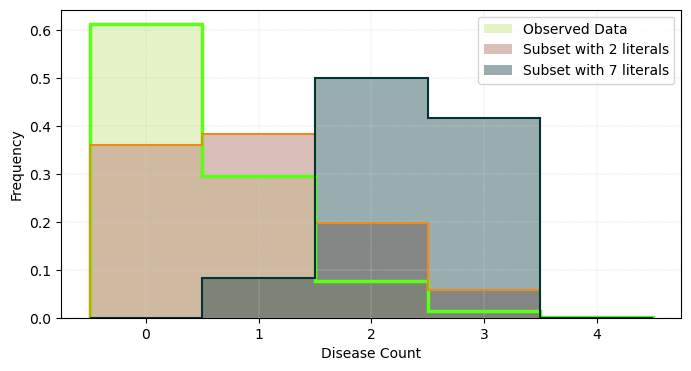

In [173]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming poisData and dataframes are defined and available
x = np.arange(0, max(poisData) + 1)

plt.figure(figsize=(8, 4))
# First plot the filled histograms
plt.hist(poisData, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.8, color='#DEEFB7', label='Observed Data')
plt.hist(dataframes['df_5'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.6, color='#C2948A', label='Subset with 2 literals')
plt.hist(dataframes['df_0.8'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.4, color='#023436', label='Subset with 7 literals')

# Then overlay with the step histograms for outlines
plt.hist(poisData, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='lightblue', histtype='step', linewidth=2.5, edgecolor='#5AFF15')
plt.hist(dataframes['df_5'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='#721121', histtype='step', linewidth=1.5, edgecolor='#EF8A17')
plt.hist(dataframes['df_0.8'].MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='#721121', histtype='step', linewidth=1.5, edgecolor='#023436')

# plt.title('Histograms of Observed and Data Subsets')
plt.xlabel('Disease Count')
plt.ylabel('Frequency')
plt.xticks(x)
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.3)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Assuming `dataframes` dictionary contains pandas DataFrames with 'index' as their index.
set_1 = set(dataframes['df_0.4'].index)
set_2 = set(dataframes['df_0.5'].index)
set_3 = set(dataframes['df_1.0'].index)

# Set the figure size
plt.figure(figsize=(10, 8))  # You can adjust these dimensions as needed

# Create the Venn diagram
venn_diagram = venn3([set_1, set_2, set_3], ('Subset 1', 'Subset 2', 'Subset 3'))

# Customize the appearance of the Venn diagram (check these IDs carefully)
if venn_diagram.get_label_by_id('100'):
    venn_diagram.get_label_by_id('100').set_text('Set 1')
if venn_diagram.get_label_by_id('010'):
    venn_diagram.get_label_by_id('010').set_text('Set 2')
if venn_diagram.get_label_by_id('001'):
    venn_diagram.get_label_by_id('001').set_text('Set 3')

# Space the circles or sets
if venn_diagram.get_patch_by_id('100'):
    venn_diagram.get_patch_by_id('100').set_color('skyblue')
if venn_diagram.get_patch_by_id('010'):
    venn_diagram.get_patch_by_id('010').set_color('lightgreen')
if venn_diagram.get_patch_by_id('001'):
    venn_diagram.get_patch_by_id('001').set_color('lightcoral')

# Display the Venn diagram
plt.title("Venn Diagram of Unique Observations")
plt.show()


In [592]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

# Example DataFrames' indices, assumed to be in your 'dataframes' dictionary
set_1 = set(dataframes['df_0.5'].index)
set_2 = set(dataframes['df_1.0'].index)
set_3 = set(dataframes['df_3.5'].index)

# Create the Venn diagram
fig, ax = plt.subplots()
venn_diagram = venn3([set_1, set_2, set_3], ('3 literals', '2 literals', '1 literal'), ('salmon', '#6A66A2', 'gray'))


# Get the total number of elements to normalize font sizes
total_elements = sum([len(s) for s in [set_1, set_2, set_3]])
min_font_size = 10  # Minimum font size
max_font_size = 20  # Maximum font size

# Normalize and set the font size for each label in the Venn diagram
for subset in venn_diagram.subset_labels:
    if subset is not None:
        size = int(subset.get_text())
        normalized_size = (size / total_elements) * (max_font_size - min_font_size) + min_font_size
        subset.set_fontsize(normalized_size)

# Annotating the sizes of each set next to the diagram
plt.text(-0.5, 0.4, f'Size: {len(set_1)}', fontsize=10, ha='right')
plt.text(0.5, 0.5, f'Size: {len(set_2)}', fontsize=10, ha='left')
plt.text(0.4, -0.5, f'Size: {len(set_3)}', fontsize=10, ha='center')

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


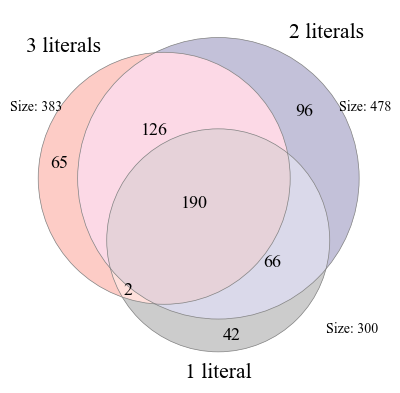

In [294]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 13

# Example DataFrames' indices, assumed to be in your 'dataframes' dictionary
set_1 = set(dataframes['df_3.5'].index)
set_2 = set(dataframes['df_4.5'].index)
set_3 = set(dataframes['df_9.5'].index)

# Create the Venn diagram
fig, ax = plt.subplots()
venn_diagram = venn3([set_1, set_2, set_3], ('3 literals', '2 literals', '1 literal'), ('salmon', '#6A66A2', 'gray'))

# Add optional circle lines for better visibility
venn_circles = venn3_circles([set_1, set_2, set_3], linestyle='solid', linewidth=0.5, color='gray')

# # Adjusting font size directly is possible
# for label in venn_diagram.set_labels:
#     label.set_fontsize(12)  # Set a uniform font size for set labels
# for label in venn_diagram.subset_labels:
#     label.set_fontsize(10)  # Set a uniform smaller font size for subset labels

    # Annotating the sizes of each set next to the diagram
# plt.text(-0.5, 0.4, f'Size: {len(set_1)}', fontsize=10, ha='right')
# plt.text(0.5, 0.5, f'Size: {len(set_2)}', fontsize=10, ha='left')
# plt.text(0.4, -0.5, f'Size: {len(set_3)}', fontsize=10, ha='center')
plt.text(-0.5, 0.3, f'Size: {len(set_1)}', fontsize=10, ha='right')
plt.text(0.5, 0.3, f'Size: {len(set_2)}', fontsize=10, ha='left')
plt.text(0.55, -0.5, f'Size: {len(set_3)}', fontsize=10, ha='center')

# Save the figure as .eps
fig.savefig("/Users/kayadetunji/Downloads/figs/venn_neg_ag.eps", format='eps')

# Save the figure as a vector-based PDF
fig.savefig("/Users/kayadetunji/Downloads/figs/venn_neg_ag.pdf", format='pdf')
plt.show()


In [53]:
scoring_function = Poisson(direction='positive') 
# HIGH(10): 0.4, 0.5,1.0,2.0, # LOW(10): 0.3, 0.8, 1.2, 1.5, 3.5, 4.5, 7.5/8.5 - AG
# HIGH(10): 0.8, 1.0,2.0,6.0,7.5 # LOW(10): 0.5, (0.8), 2.2, 3.5, 4.5, 6.5, 9.5 - NAI
scanner = MDSS(scoring_function)
# Perform the scan with the current penalty value
subset, score = scanner.scan(dff_2[search_space1], dff_2['MorbidityCount'], dff_2['expectationPoisson'], cpu=0.95,
                                penalty=0.05, num_iters=10, contiguous=contiguous.copy())
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]
not_tempdf = dff_2.loc[~to_choose]

triglycerides phase1[1.0 - 5.34] AND hdl phase1[1.06 - 3.78] AND friedewald ldl c phase1[1.67 - 7.6] AND bmi c phase1[21.46 - 68.02] AND waist hip r c phase1[0.86 - 1.16] AND diabetes history phase1[1]


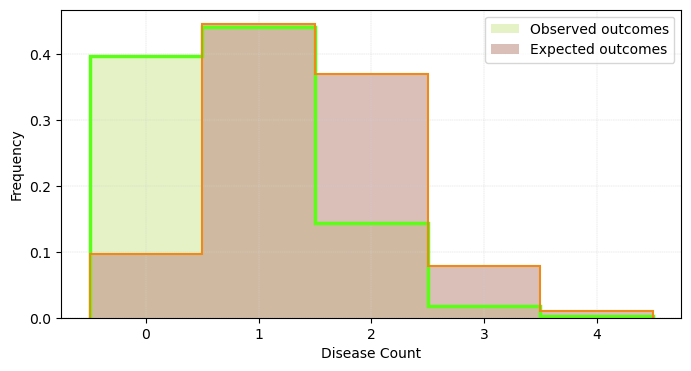

In [39]:
plt.figure(figsize=(8, 4))
# First plot the filled histograms
plt.hist(poisData, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.8, color='#DEEFB7', label='Observed outcomes')
plt.hist(temp_df.MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.6, color='#C2948A', label='Expected outcomes')
# plt.hist(not_tempdf.MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.4, color='#023436', label='Subset with 7 literals')

# Then overlay with the step histograms for outlines
plt.hist(poisData, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='lightblue', histtype='step', linewidth=2.5, edgecolor='#5AFF15')
plt.hist(temp_df.MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='#721121', histtype='step', linewidth=1.5, edgecolor='#EF8A17')
# plt.hist(not_tempdf.MorbidityCount, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, color='#721121', histtype='step', linewidth=1.5, edgecolor='#023436')

# plt.title('Histograms of Observed and Data Subsets')
plt.xlabel('Disease Count')
plt.ylabel('Frequency')
plt.xticks(x)
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.3)
plt.show()

In [21]:
import numpy as np
import scipy.stats as stats

# Example data
data_group1 = dff_2['MorbidityCount']
data_group2 = temp_df['MorbidityCount']

# Total cases for each group
cases_group1 = np.sum(data_group1)
cases_group2 = np.sum(data_group2)

# Check for the Central Limit Theorem applicability (point 1)
# Rule of thumb: at least 5 to 10 events per group
clt_applicable_group1 = cases_group1 >= 5
clt_applicable_group2 = cases_group2 >= 5

# Assuming equal person-time for simplicity
person_time_group1 = dff_2['MorbidityCount'].mean()
person_time_group2 = temp_df['MorbidityCount'].mean()

# Calculate Incidence Density for each group
incidence_density_group1 = cases_group1 / person_time_group1
incidence_density_group2 = cases_group2 / person_time_group2

# Calculate IDR
IDR = incidence_density_group1 / incidence_density_group2

# Calculate Log-IDR and its standard error
log_IDR = np.log(IDR)
SE_log_IDR = np.sqrt((1/cases_group1) + (1/cases_group2))

# Calculate 95% Confidence Interval for Log-IDR
CI_lower_log = log_IDR - 1.96 * SE_log_IDR
CI_upper_log = log_IDR + 1.96 * SE_log_IDR

# Transform the CI back to the original scale
CI_lower = np.exp(CI_lower_log)
CI_upper = np.exp(CI_upper_log)

# Check for meaningful confidence intervals (point 3)
# Confidence intervals should not include negative values or be excessively wide
meaningful_ci = CI_lower > 0 and (CI_upper - CI_lower) < np.inf

# Output the results
print("Central Limit Theorem applicability in Group 1:", clt_applicable_group1)
print("Central Limit Theorem applicability in Group 2:", clt_applicable_group2)
print("Meaningful confidence interval:", meaningful_ci)
print("95% Confidence Interval:", CI_lower, CI_upper)



Central Limit Theorem applicability in Group 1: True
Central Limit Theorem applicability in Group 2: True
Meaningful confidence interval: True
95% Confidence Interval: 3.1329777314480225 3.8834646885279103


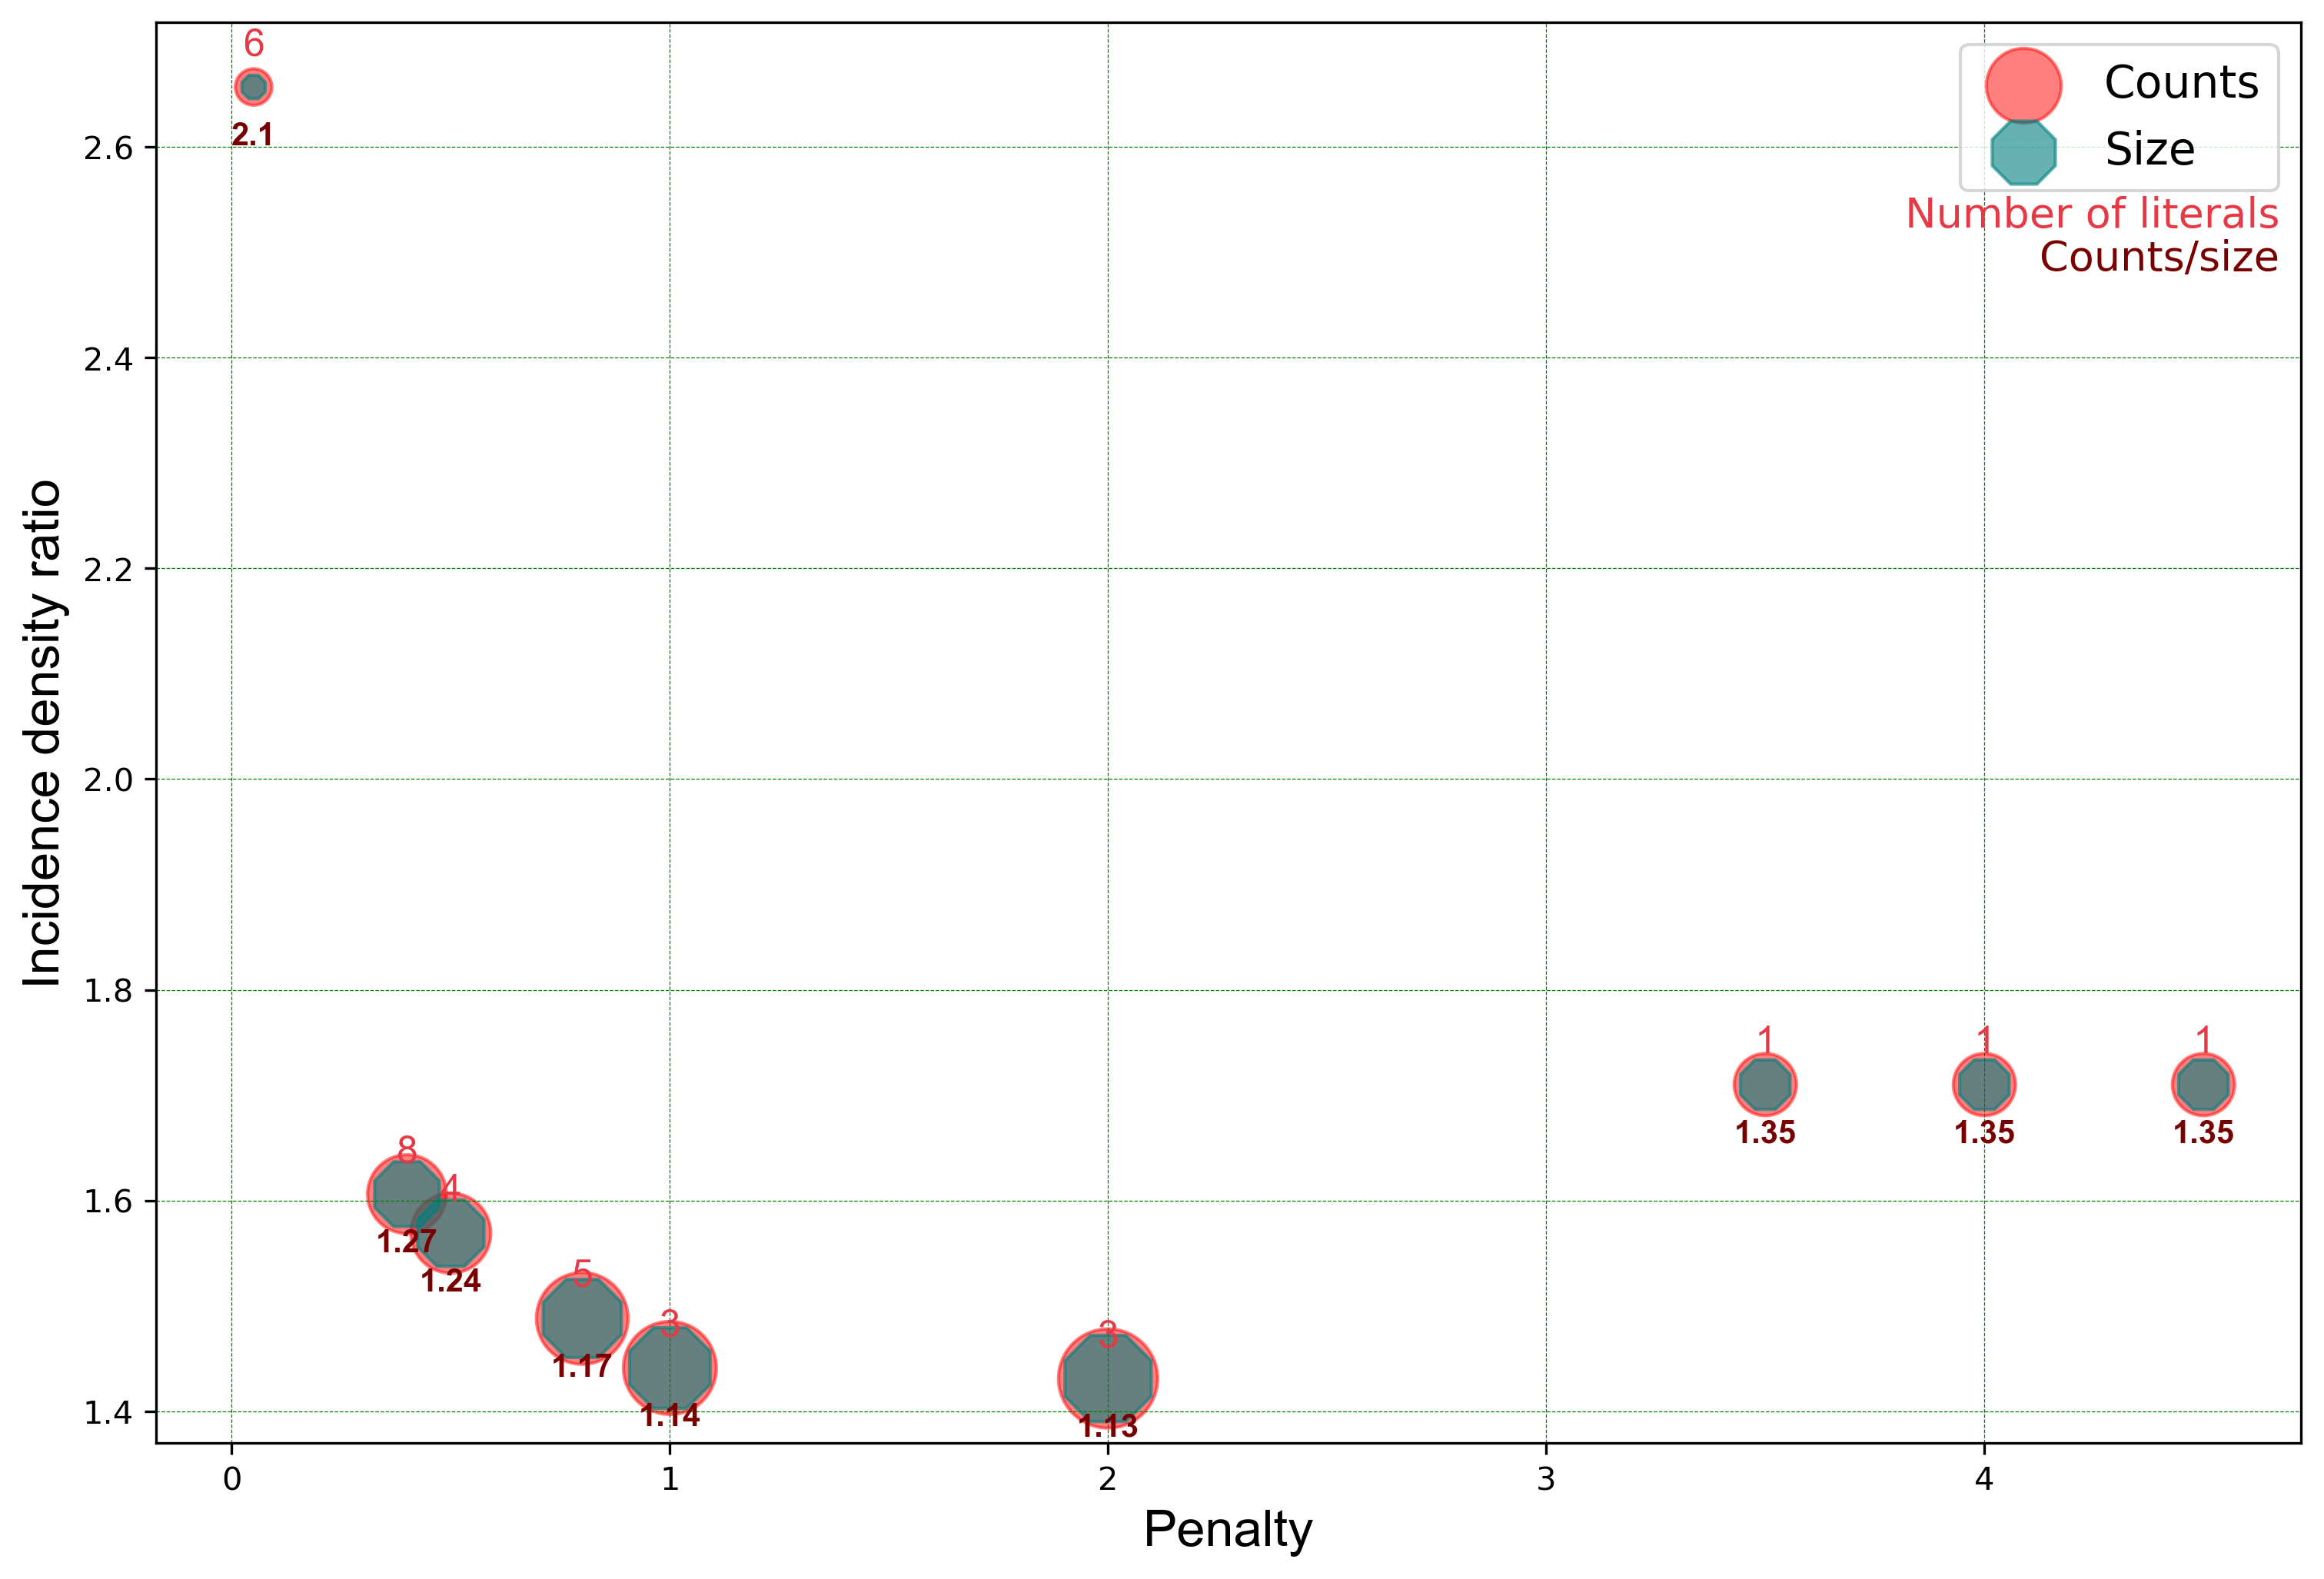

In [79]:
import matplotlib.path as mpath
# datum = {'size': [36,250,333,418,418,536,467,439,315,315],
# 'counts': [0,98,140,196,196,272,246,225,156,156],
# 'IDR': [0,0.171,0.227,0.285,0.285,0.366,0.319,0.3,0.215,0.215],
# 'scores': [25.136,23.768,25.956,24.557,23.057,20.45,14.935,15.171,14.517,14.017],
# 'literals': [6,6,5,3,3,3,2,2,1,1],
# 'penalty': [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
# }

df = results_df.copy()
df['count/size']=np.round(df['Counts']/df['Size'],2)

# Plotting
fig=plt.figure(figsize=(12, 8),dpi=300)
ax = fig.add_subplot()

# Plot Odds for Bernoulli
# plt.scatter(df['penalty'], df['IDR'], s=df['size']*2, label='Size', alpha=0.7)

# Plot counts
plt.scatter(df['Penalty'], df['IDR'], s=df['Counts']*2, marker='o', label='Counts', color='red', alpha=0.5)
# Plot size
plt.scatter(df['Penalty'], df['IDR'], s=df['Size']*2, marker='8', label='Size', color='teal', alpha=0.6)
# Plot Odds for Bernoulli
# plt.plot(df['penalty'], df['IDR'], marker='*', label='Bernoulli')

# Annotate the size values for Bernoulli
for i, txt in enumerate(df['No of literals']):
    plt.annotate(txt, (df['Penalty'][i], df['IDR'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontname="Arial", fontsize=12, color='#e63946')

# Annotate the size values for Bernoulli
for i, txt in enumerate(df['count/size']):
    plt.annotate(txt, (df['Penalty'][i], df['IDR'][i]), textcoords="offset points", xytext=(0,-18), ha='center', fontname="Arial",fontweight="bold", color='#780000')

# Add labels and title
plt.xlabel('Penalty', fontsize=16, fontname="Arial")
plt.ylabel('Incidence density ratio', fontsize=16, fontname="Arial")
# plt.title('Plot for condition counts with number of literals (Agincourt)', fontname="Arial", fontsize=14,fontweight="bold")
plt.legend(fontsize="14",loc='upper right')
# plt.text(1, 2, 'Normal Font',  fontsize=16)
ax.text(0.99, 0.85, 'Number of literals',verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,color='#e63946', fontsize=13)
ax.text(0.99, 0.82, 'Counts/size',verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,color='#780000', fontsize=13)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.3)
# Show the plot
plt.show()

In [170]:
import pandas as pd
import numpy as np

# Load your dataframe (assuming it is a CSV for this example)
# df = pd.read_csv('your_file.csv')

# For demonstration, I'll create a sample dataframe similar to your data
np.random.seed(0)  # For reproducibility
data = {
    'MorbidityCount': np.random.choice([0, 1, 2, 3, 4], 491, p=[0.4, 0.3, 0.2, 0.08, 0.02]),
    'Age': np.random.normal(50, 10, 491),
    'Gender': np.random.choice([0, 1], 491),
    'History of diabetes': np.random.choice([0, 1], 491),
    'History of coronary heart diseases': np.random.choice([0, 1], 491),
    'History of vascular diseases': np.random.choice([0, 1], 491),
    'History of smoking': np.random.choice([0, 1], 491),
    'History of hypertension': np.random.choice([0, 1], 491),
    'History of dyslipidemia': np.random.choice([0, 1], 491),
    'History of obesity': np.random.choice([0, 1], 491),
}

df = pd.DataFrame(data)

# Group by MorbidityCount
grouped = df.groupby('MorbidityCount')

# Initialize a results dictionary
results = {'Variables': [], 'Original data (N = 491)': []}
for count in range(5):
    results[f'MorbidityCount = {count} (N = {grouped.size().get(count, 0)})'] = []

# For continuous variables, compute mean and std
continuous_vars = ['Age']
for var in continuous_vars:
    results['Variables'].append(var)
    results['Original data (N = 491)'].append(f"{df[var].mean():.2f} ± {df[var].std():.2f}")
    for count in range(5):
        if count in grouped.groups:
            count_data = grouped.get_group(count)[var]
            results[f'MorbidityCount = {count} (N = {len(count_data)})'].append(f"{count_data.mean():.2f} ± {count_data.std():.2f}")
        else:
            results[f'MorbidityCount = {count} (N = 0)'].append('N/A')

# For categorical variables, compute count and percentage
categorical_vars = ['Gender', 'History of diabetes', 'History of coronary heart diseases', 'History of vascular diseases', 'History of smoking', 'History of hypertension', 'History of dyslipidemia', 'History of obesity']
for var in categorical_vars:
    results['Variables'].append(var)
    total_count = df[var].value_counts().to_dict()
    results['Original data (N = 491)'].append(f"{total_count.get(1, 0)} ({total_count.get(1, 0) / len(df) * 100:.2f}%)")
    for count in range(5):
        if count in grouped.groups:
            count_data = grouped.get_group(count)[var].value_counts().to_dict()
            results[f'MorbidityCount = {count} (N = {len(grouped.get_group(count))})'].append(f"{count_data.get(1, 0)} ({count_data.get(1, 0) / len(grouped.get_group(count)) * 100:.2f}%)")
        else:
            results[f'MorbidityCount = {count} (N = 0)'].append('N/A')

# Convert results to DataFrame for better display
resultsee_df = pd.DataFrame(results)
resultsee_df


,Variables,Original data (N = 491),MorbidityCount = 0 (N = 203),MorbidityCount = 1 (N = 149),MorbidityCount = 2 (N = 82),MorbidityCount = 3 (N = 48),MorbidityCount = 4 (N = 9)
0,Age,49.07 ± 9.90,49.49 ± 10.01,48.57 ± 10.43,48.49 ± 9.15,49.27 ± 9.65,52.01 ± 6.53
1,Gender,266 (54.18%),114 (56.16%),75 (50.34%),47 (57.32%),24 (50.00%),6 (66.67%)
2,History of diabetes,260 (52.95%),109 (53.69%),76 (51.01%),45 (54.88%),24 (50.00%),6 (66.67%)
3,History of coronary heart diseases,241 (49.08%),101 (49.75%),78 (52.35%),37 (45.12%),21 (43.75%),4 (44.44%)
4,History of vascular diseases,240 (48.88%),103 (50.74%),65 (43.62%),49 (59.76%),17 (35.42%),6 (66.67%)
5,History of smoking,255 (51.93%),104 (51.23%),81 (54.36%),41 (50.00%),26 (54.17%),3 (33.33%)
6,History of hypertension,252 (51.32%),108 (53.20%),76 (51.01%),38 (46.34%),24 (50.00%),6 (66.67%)
7,History of dyslipidemia,238 (48.47%),97 (47.78%),79 (53.02%),40 (48.78%),20 (41.67%),2 (22.22%)
8,History of obesity,240 (48.88%),103 (50.74%),69 (46.31%),42 (51.22%),20 (41.67%),6 (66.67%)


In [ ]:
# datum = {'size': [36,250,333,418,418,536,467,439,315,315],
# 'counts': [0,98,140,196,196,272,246,225,156,156],
# 'IDR': [0,0.171,0.227,0.285,0.285,0.366,0.319,0.3,0.215,0.215],
# 'scores': [25.136,23.768,25.956,24.557,23.057,20.45,14.935,15.171,14.517,14.017],
# 'literals': [6,6,5,3,3,3,2,2,1,1],
# 'penalty': [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]}

df = pd.DataFrame(datum)

# Plotting
fig=plt.figure(figsize=(12, 8))
ax = fig.add_subplot()

# Plot Odds for Bernoulli
# plt.scatter(df['penalty'], df['IDR'], s=df['size']*2, label='Size', alpha=0.7)

# Plot Odds for Bernoulli
plt.scatter(df['penalty'], df['IDR'], s=df['counts']*2, label='Counts', color='teal', alpha=0.6)
# Plot Odds for Bernoulli
# plt.plot(df['penalty'], df['IDR'], marker='*', label='Bernoulli')

# Annotate the size values for literals
for i, txt in enumerate(df['literals']):
    plt.annotate(txt, (df['penalty'][i], df['IDR'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontname="Arial", fontsize=12, color='brown')

# Annotate the size values for counts
for i, txt in enumerate(df['counts']):
    plt.annotate(txt, (df['penalty'][i], df['IDR'][i]), textcoords="offset points", xytext=(0,-4), ha='center', fontname="Arial",fontweight="bold")

# Add labels and title
plt.xlabel('Penalty', fontsize=14, fontname="Arial")
plt.ylabel('Incidence density ratio', fontsize=14, fontname="Arial")
plt.title('Plot for disease counts with number of literals', fontname="Arial", fontsize=14,fontweight="bold")
plt.legend(fontsize="14")
# plt.text(1, 2, 'Normal Font',  fontsize=16)
ax.text(0.99, 0.88, 'Number of literals',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='brown', fontsize=13)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.3)
# Show the plot
plt.show()

In [22]:
results_df.columns

Index(['Penalty', 'No of literals', 'Subset', 'Size', 'Counts', 'IDR',
       'Size (%)', 'Count (%)', 'P value'],
      dtype='object')

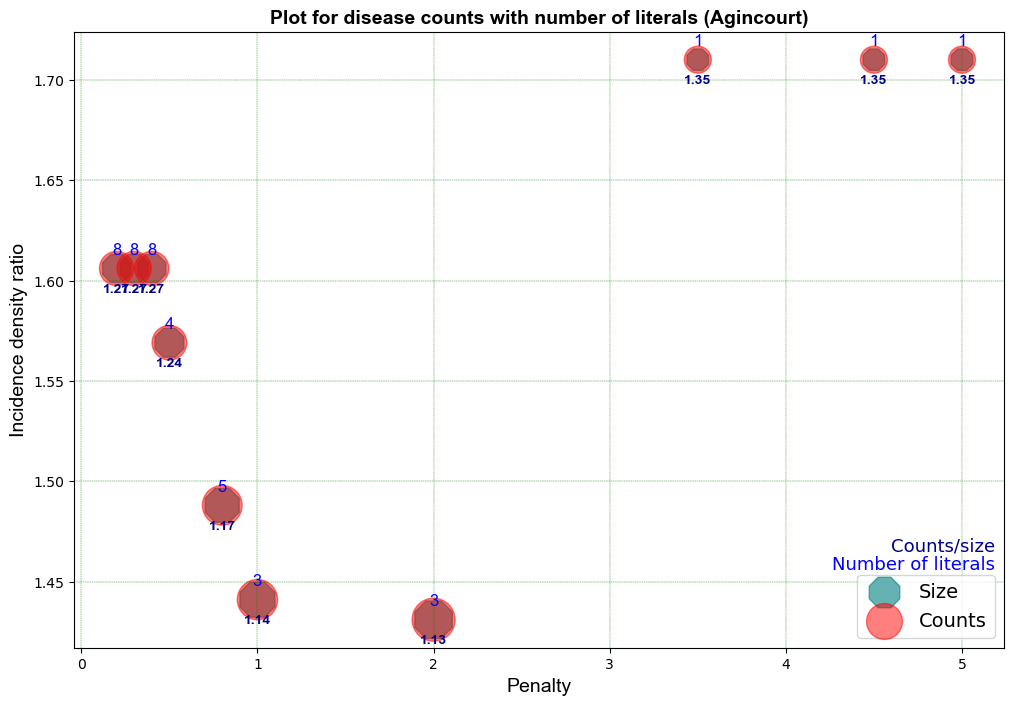

In [49]:
import matplotlib.path as mpath
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D

# datum = {'size': [321,270,276,445,227,227,420,227,420,420],
# 'counts': [398,339,344,500,289,289,470,289,470,470],
# 'IDR': [0.219,0.184,0.188,0.304,0.155,0.155,0.287,0.155,0.287,0.287],
# 'scores': [32.546,28.72,26.255,23.291,24.427,23.427,19.956,21.427,17.956,16.956],
# 'literals': [8,	4,	4,	3,	2,	2,	2,	2,	2,	2],
# 'penalty': [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
# }

# Marker
# r'$\clubsuit$'

df = results_df.copy()
# df['size'] = np.round(df['Size']/df['Size'].sum()*100,2)
# df['counts'] = np.round(df['Counts']/df['Counts'].sum()*100,2)

# df = pd.DataFrame(datum)
df['count/size']=np.round(df['Counts']/df['Size'],2)

# Plotting
fig=plt.figure(figsize=(12, 8))
ax = fig.add_subplot()

# Plot Odds for Bernoulli
# plt.scatter(df['penalty'], df['IDR'], s=df['size']*2, label='Size', alpha=0.7)

# Plot size
plt.scatter(df['Penalty'], df['IDR'], s=df['Size']*2, marker='8', label='Size', color='teal', alpha=0.6)
# Plot counts
plt.scatter(df['Penalty'], df['IDR'], s=df['Counts']*2, marker='o', label='Counts', color='red', alpha=0.5)
# Plot Odds for Bernoulli
# plt.plot(df['penalty'], df['IDR'], marker='*', label='Bernoulli')

# Annotate the size values for Bernoulli
for i, txt in enumerate(df['No of literals']):
    plt.annotate(txt, (df['Penalty'][i], df['IDR'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontname="Arial", fontsize=12, color='blue')

# Annotate the size values for Bernoulli
for i, txt in enumerate(df['count/size']):
    plt.annotate(txt, (df['Penalty'][i], df['IDR'][i]), textcoords="offset points", xytext=(0,-17), ha='center', fontname="Arial",fontweight="bold", color='darkblue')

# Add labels and title
plt.xlabel('Penalty', fontsize=14, fontname="Arial")
plt.ylabel('Incidence density ratio', fontsize=14, fontname="Arial")
plt.title('Plot for disease counts with number of literals (Agincourt)', fontname="Arial", fontsize=14,fontweight="bold")
plt.legend(fontsize="14",loc='lower right')
# plt.text(1, 2, 'Normal Font',  fontsize=16)
ax.text(0.99, 0.12, 'Number of literals',verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,color='blue', fontsize=13)
ax.text(0.99, 0.15, 'Counts/size',verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,color='darkblue', fontsize=13)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.3)
# Show the plot
plt.show()

In [34]:
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Counts': disease_counts,
    'IDR': IDR_results,
    'Size (%)': size_percent,
    'Count (%)': counts_percent,
    'P value': p_values,
})

# Display the DataFrame
results_df


,Penalty,No of literals,Subset,Size,Counts,IDR,Size (%),Count (%),P value
0,0.5,6,triglycerides qc[0.25 - 1.12] AND visceral fat...,36,0,0.000,2.46,0.00,NaN
1,1.0,6,cimt mean max[0.41 - 0.83] AND bmi c qc[14.53 ...,250,98,0.502,17.06,8.56,5.517345e-11
2,1.5,5,cimt mean max[0.41 - 0.68] AND friedewald ldl ...,333,140,0.538,22.73,12.23,4.349085e-12
3,2.0,3,waist circumference qc[510.0 - 950.0] AND chol...,418,196,0.600,28.53,17.12,3.857221e-11
4,2.5,3,cimt mean max[0.41 - 0.68] AND waist circumfer...,418,196,0.600,28.53,17.12,3.857221e-11
5,3.0,3,friedewald ldl c c qc[-3.31 - 2.79] AND waist ...,536,272,0.649,36.59,23.76,1.525983e-10
6,3.5,2,bmi c qc[14.53 - 26.06] AND age[40.0 - 53.0],467,246,0.674,31.88,21.48,1.972122e-08
7,4.0,2,visceral fat qc[2.82 - 5.91] AND cimt mean max...,439,225,0.656,29.97,19.65,7.199861e-09
8,4.5,1,waist circumference qc[510.0 - 780.0],315,156,0.634,21.50,13.62,8.982408e-08
9,5.0,1,waist circumference qc[510.0 - 780.0],315,156,0.634,21.50,13.62,8.982408e-08


In [65]:
results_df.to_csv('Poisson_norm_counts_neg1_NAI.csv', index=False)

In [543]:
np.unique(dataframes['df_0.5'].MorbidityCount, return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 45, 176,  80,  18,   2]))

In [63]:
dataframes['df_1.5'].iloc[1:9,-3].sum()
# np.unique(dataframes['df_1.5'].iloc[1:8,-3], return_counts=True)

10

In [544]:
dataframes['df_4.5']['MorbidityCount'].value_counts()

1    210
2     99
0     91
3     18
4      2
Name: MorbidityCount, dtype: int64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


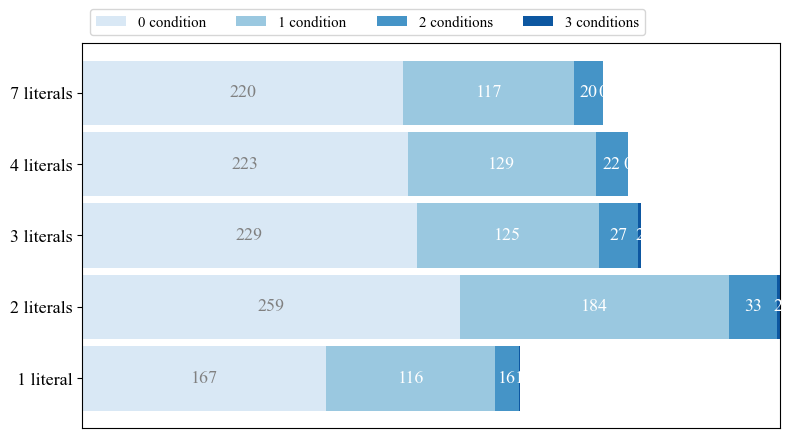

In [295]:
category_names = ['0 condition', '1 condition',
                  '2 conditions', '3 conditions', '4 conditions']

results1 = {
    '7 literals': dataframes['df_0.2']['MorbidityCount'].value_counts().values,
    '4 literals': dataframes['df_2.0']['MorbidityCount'].value_counts().values,
    '3 literals': dataframes['df_3.5']['MorbidityCount'].value_counts().values,
    '2 literals': dataframes['df_4.5']['MorbidityCount'].value_counts().values,
    '1 literal': dataframes['df_9.5']['MorbidityCount'].value_counts().values, 
    # '2 literals(v2)': dataframes['df_3.5']['MorbidityCount'].value_counts().values,   0.4, 0.5,1.0,2.0
}


def survey(results1, category_names):
    labels = list(results1.keys())
    data = list(results1.values())
    
    # Determine the maximum length of the arrays in data
    max_length = max(len(arr) for arr in data)
    
    # Pad arrays with zeros to ensure they all have the same length
    padded_data = np.array([np.pad(arr, (0, max_length - len(arr)), 'constant') for arr in data])
    
    data_cum = padded_data.cumsum(axis=1)
    category_colors = plt.colormaps['Blues'](np.linspace(0.15, 0.85, padded_data.shape[1]))

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(padded_data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = padded_data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.9,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'gray'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    return fig, ax

fig, ax = survey(results1, category_names)

fig.savefig("/Users/kayadetunji/Downloads/figs/dist_neg_ag.eps", format='eps')
fig.savefig("/Users/kayadetunji/Downloads/figs/dist_neg_ag.pdf", format='pdf')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


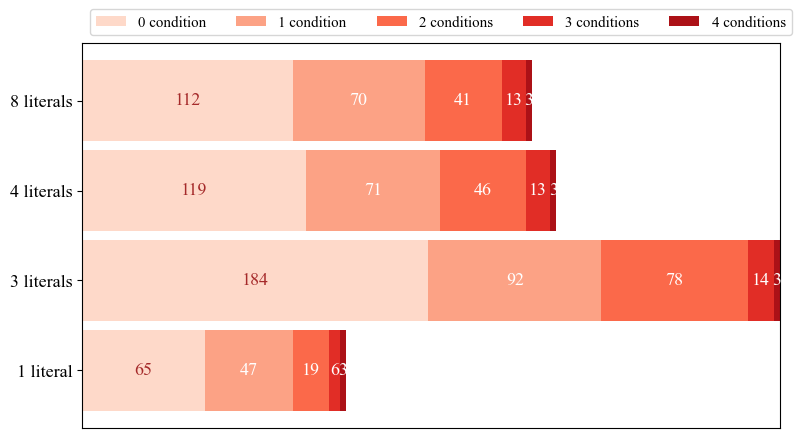

In [290]:
category_names = ['0 condition', '1 condition',
                  '2 conditions', '3 conditions', '4 conditions']

results1 = {
    '8 literals': dataframes['df_0.4']['MorbidityCount'].value_counts().values,
    '4 literals': dataframes['df_0.5']['MorbidityCount'].value_counts().values,
    '3 literals': dataframes['df_1.0']['MorbidityCount'].value_counts().values,
    # '3 literals(v2)': dataframes['df_2.0']['MorbidityCount'].value_counts().values,
    '1 literal': dataframes['df_3.5']['MorbidityCount'].value_counts().values, 
    # '2 literals(v2)': dataframes['df_3.5']['MorbidityCount'].value_counts().values,   0.4, 0.5,1.0,2.0
}
# results1 = {
#     '8 literals': dataframes['df_0.8']['MorbidityCount'].value_counts().values,
#     '4 literals': dataframes['df_1.0']['MorbidityCount'].value_counts().values,
#     '3 literals': dataframes['df_4.5']['MorbidityCount'].value_counts().values,
#     '2 literals': dataframes['df_6.5']['MorbidityCount'].value_counts().values,
#     # '1 literal': dataframes['df_7.5']['MorbidityCount'].value_counts().values, 
#     # '2 literals(v2)': dataframes['df_3.5']['MorbidityCount'].value_counts().values,   0.4, 0.5,1.0,2.0
# }


def survey(results1, category_names):
    labels = list(results1.keys())
    data = list(results1.values())
    
    # Determine the maximum length of the arrays in data
    max_length = max(len(arr) for arr in data)
    
    # Pad arrays with zeros to ensure they all have the same length
    padded_data = np.array([np.pad(arr, (0, max_length - len(arr)), 'constant') for arr in data])
    
    data_cum = padded_data.cumsum(axis=1)
    category_colors = plt.colormaps['Reds'](np.linspace(0.15, 0.85, padded_data.shape[1]))

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(padded_data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = padded_data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.9,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'brown'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    return fig, ax

fig, ax = survey(results1, category_names)
# Save the figure as .eps
fig.savefig("/Users/kayadetunji/Downloads/figs/dist_pos_ag.eps", format='eps')

# Save the figure as a vector-based PDF
fig.savefig("/Users/kayadetunji/Downloads/figs/dist_pos_ag.pdf", format='pdf')
plt.show()

In [182]:
# Identify unique observations from the datasets
unique_ids = np.unique(np.concatenate([dff.index,dataframes['df_0.4'].index, dataframes['df_0.5'].index, dataframes['df_1.0'].index,dataframes['df_2.0'].index, dataframes['df_3.5'].index]))

# Create a DataFrame with values of 1 in the baseline column and 0 or 1 in the other columns
final_df = pd.DataFrame(index=unique_ids, columns=['8_literals', '4_literals', '3_literals', '3_literals (v2)', '1_literal'])
# qwe = pd.DataFrame(final_df[['8_literals', '4_literals', '3_literals', '3_literals (v2)', '1_literal']].sum(axis=1) > 0).astype(int)
# Set values based on the presence of IDs in the datasets
# final_df['Baseline'] = 1
#  'all literals' contains all indexes
# Add a column for 'Not Used' indexes

# final_df['Not Used'] = qwe[0]
# final_df['all literals'] = final_df.index.isin(dff.index).astype(int)
final_df['8_literals'] = final_df.index.isin(dataframes['df_0.4'].index).astype(int)
final_df['4_literals'] = final_df.index.isin(dataframes['df_0.5'].index).astype(int)
final_df['3_literals'] = final_df.index.isin(dataframes['df_1.0'].index).astype(int)
final_df['3_literals (v2)'] = final_df.index.isin(dataframes['df_2.0'].index).astype(int)
final_df['1_literal'] = final_df.index.isin(dataframes['df_3.5'].index).astype(int)

# Display the final DataFrame
print(final_df)

      8_literals  4_literals  3_literals  3_literals (v2)  1_literal
0              0           1           1                0          1
1              1           1           1                1          0
2              0           0           0                0          0
3              0           0           0                1          0
4              0           0           0                0          0
...          ...         ...         ...              ...        ...
1390           0           0           0                0          1
1391           0           0           0                1          0
1392           0           0           0                1          0
1393           0           0           0                0          0
1394           0           0           0                0          0

[1395 rows x 5 columns]


In [655]:
qwe = pd.DataFrame(final_df[['8_literals', '4_literals', '3_literals', '3_literals (v2)', '1_literal']].sum(axis=1) > 0).astype(int)

In [638]:
final_df['Not Used'].value_counts()

0    1395
Name: Not Used, dtype: int64

In [77]:
# Identify unique observations from the datasets
unique_ids = np.unique(np.concatenate([dataframes['df_0.5'].index, dataframes['df_1'].index, dataframes['df_1.5'].index,dataframes['df_2'].index, dataframes['df_2.5'].index, dataframes['df_3.5'].index, dataframes['df_10'].index,]))

# Create a DataFrame with values of 1 in the baseline column and 0 or 1 in the other columns
final_df = pd.DataFrame(index=unique_ids, columns=['8_literals', '4_literals', '4_literals-1','3_literals', '2_literals', '2_literals-1', '1_literal'])

# Set values based on the presence of IDs in the datasets
# final_df['Baseline'] = 1
final_df['8_literals'] = final_df.index.isin(dataframes['df_0.5'].index).astype(int)
final_df['4_literals'] = final_df.index.isin(dataframes['df_1'].index).astype(int)
final_df['4_literals-1'] = final_df.index.isin(dataframes['df_1.5'].index).astype(int)
final_df['3_literals'] = final_df.index.isin(dataframes['df_2'].index).astype(int)
final_df['2_literals'] = final_df.index.isin(dataframes['df_2.5'].index).astype(int)
final_df['2_literals-1'] = final_df.index.isin(dataframes['df_3.5'].index).astype(int)
final_df['1_literal'] = final_df.index.isin(dataframes['df_10'].index).astype(int)

# Display the final DataFrame
print(final_df)

      8_literals  4_literals  4_literals-1  3_literals  2_literals  \
1              1           1             1           1           1   
2              0           0             0           0           0   
3              0           0             0           1           0   
6              0           1             1           1           1   
7              0           0             0           1           0   
...          ...         ...           ...         ...         ...   
1458           1           1             1           1           1   
1459           0           1             1           0           1   
1460           0           0             0           0           1   
1461           0           0             0           1           0   
1462           1           1             1           1           1   

      2_literals-1  1_literal  
1                1          1  
2                0          1  
3                0          0  
6                1          1  

In [189]:
# get coordinates where event occurs (value=1)
row_paths, col_paths = np.where(final_df.eq(1))
mask = pd.DataFrame(data= {'rows':row_paths, 'cols':col_paths})

# aggregate by row to get application's path
agg_mask = mask.groupby('rows').apply(lambda x: [x for x in x.cols])
agg_mask.tail()

rows
1385          [2, 3]
1388    [0, 1, 2, 3]
1390             [4]
1391             [3]
1392             [3]
dtype: object

In [190]:
all_events = []

# get pair of source and target
for row in agg_mask:
    for index in range(len(row)-1):
        all_events.append([row[index], row[index+1]])
        
# create df for aggregation        
sankey_ST = pd.DataFrame(data=all_events)
sankey_ST = sankey_ST.rename(columns={0:'source', 1:'target'})
sankey_ST = sankey_ST.value_counts().reset_index()
sankey_ST = sankey_ST.rename(columns={0:'value'})

sankey_ST.head()

,source,target,value
0,0,1,239
1,1,2,237
2,2,3,223
3,3,4,52
4,2,4,31


In [193]:
# Assuming final_df and sankey_ST are already defined
additional_df = results_df
# Create a dictionary to map subsets to IDR values for easy lookup
subset_to_idr = pd.Series(additional_df.IDR.values, index=additional_df.Subset).to_dict()
idr_values = list(subset_to_idr.values())

# Assuming the length of idr_values aligns with final_df.columns
labels_with_idr = [
    f'{col}: {final_df[col].sum()}\n (IDR: {idr_values[i]})'
    for i, col in enumerate(final_df.columns)
]

import plotly.graph_objects as go
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        label = labels_with_idr,
        color=["#b81702", "#ec3f13", "#fa5e1f", "#ff7e33", '#8e0103']  # Set the node colors
    ),
    link=dict(
        source = sankey_ST['source'],
        target = sankey_ST['target'],
        value = sankey_ST['value'],
        # color = 'lightgray'
    ),
)])


fig.update_layout(title_text='Sankey plot for flow of literals for high risk MM in Agincourt', font_size=10)
fig.update_traces(textfont_size=16, textfont=dict(family="Times New Roman"))
fig.write_html("sankey_diagram.html")
fig.show()

In [ ]:
# Assuming final_df and sankey_ST are already defined
additional_df = results_df
# Create a dictionary to map subsets to IDR values for easy lookup
subset_to_idr = pd.Series(additional_df.IDR.values, index=additional_df.Subset).to_dict()
idr_values = list(subset_to_idr.values())

# Assuming the length of idr_values aligns with final_df.columns
labels_with_idr = [
    f'{col}: {final_df[col].sum()} (IDR: {idr_values[i]})'
    for i, col in enumerate(final_df.columns)
]

In [600]:
# Assuming final_df and sankey_ST are already defined
additional_df = results_df
# Create a dictionary to map subsets to IDR values for easy lookup
subset_to_idr = pd.Series(additional_df.IDR.values, index=additional_df.Subset).to_dict()

idr_values = list(subset_to_idr.values())

# Initialize labels_with_idr with a specific string for the first column
labels_with_idr = [
    f'First Column: {final_df.iloc[:, 0].sum()} (population)'
]

# Append the rest of the labels, starting from the second column of final_df
# Note that we adjust the index i by -1 when accessing idr_values to align with the starting point
labels_with_idr.extend([
    f'{col}: {final_df[col].sum()} (IDR: {idr_values[i-1]})'
    for i, col in enumerate(final_df.columns[1:], start=1)  # start=1 to correct enumerate starting index
])


fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=labels_with_idr
    ),
    link=dict(
        source=sankey_ST['source'],
        target=sankey_ST['target'],
        value=sankey_ST['value']
    ),
)])

fig.update_layout(title_text='Sankey plot for flow of literals for high risk MM in Agincourt', font_size=10)
fig.update_traces(textfont_size=12)
fig.show()


In [601]:
idr_values

[1.606, 1.569, 1.441, 1.431, 1.71]

In [ ]:

# One-hot encode the 'MorbidityCount' column
dff_encoded = pd.get_dummies(dff['MorbidityCount'], columns=['MorbidityCount'], prefix='DC')

dff_encoded

In [87]:
D_counts = dff_encoded.mask(dff_encoded == 1, np.nan)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

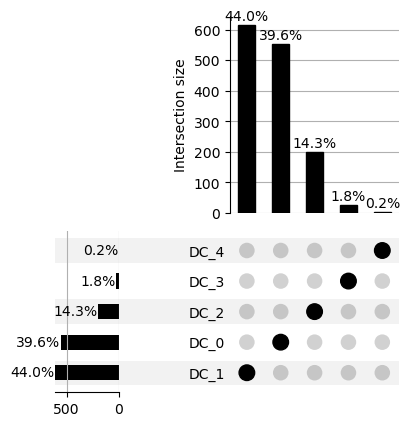

In [88]:
from upsetplot import UpSet, plot, from_indicators
from upsetplot import from_contents
# angpain.values

# ang1 = angpain.set_index(angpain.pain_qc == True).set_index(angpain.pain2_qc == 1, append=True).set_index(angpain.pain_location_12_qc == 1, append=True)
# UpSet(ang1)
upset = UpSet(from_indicators(pd.isna, data=D_counts.iloc[:,0:]), sort_by= 'cardinality', max_subset_size=1000, show_percentages=True)
# upset.style_subsets(present=["diabetes_status_c_phase1"],
#                     absent=['hypertension_status_c_phase1', 'ckd_c_phase1', 'cvd_status_phase1'],
#                     facecolor="orange",
#                     label="single counts")
# upset.style_subsets(present=["hypertension_status_c_phase1"],
#                     absent=['diabetes_status_c_phase1', 'ckd_c_phase1', 'cvd_status_phase1'],
#                     facecolor="orange",
#                     label="single counts")
# upset.style_subsets(present=["ckd_c_phase1"],
#                     absent=['hypertension_status_c_phase1', 'diabetes_status_c_phase1', 'cvd_status_phase1'],
#                     facecolor="orange",
#                     label="single counts")
upset.plot()
# upsetplot.query(ang1)
# upset = UpSet(angpain,element_size=32)

In [183]:
ang1_up = final_df.mask(final_df == 1, np.nan)

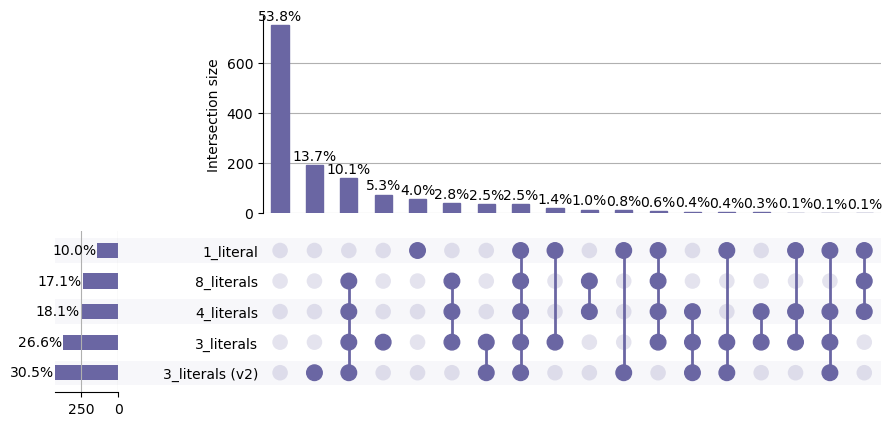

In [188]:
import upsetplot
from upsetplot import UpSet, plot, from_indicators
from upsetplot import from_contents
# angpain.values

# ang1 = angpain.set_index(angpain.pain_qc == True).set_index(angpain.pain2_qc == 1, append=True).set_index(angpain.pain_location_12_qc == 1, append=True)
# UpSet(ang1)
UpSet(from_indicators(pd.isna, data=ang1_up.iloc[:,0:]), sort_by= 'cardinality', max_subset_size=1000, facecolor='#6A66A3', show_percentages=True)


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

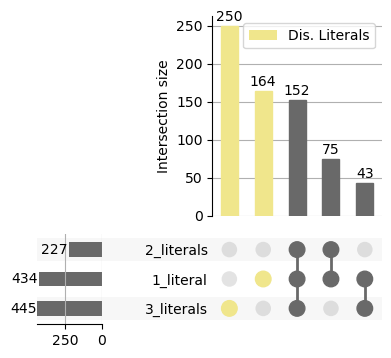

In [70]:
upset = UpSet(from_indicators(pd.isna, data=ang1_up.iloc[:,0:]), show_counts=True, max_subset_size=2000, sort_by='cardinality', facecolor='dimgrey')
upset.style_subsets(present=["1_literal"],
                    absent=['2_literals', '3_literals'],
                    facecolor="khaki",
                    # label="1 literals"
                    )
upset.style_subsets(present=["2_literals"],
                    absent=['1_literal', '3_literals'],
                    facecolor="khaki",
                    label="Dis. Literals"
                    )
upset.style_subsets(present=["3_literals"],
                    absent=['1_literal', '2_literals'],
                    facecolor="khaki",
                    # label="2 literals"
                    )
upset.plot()

In [ ]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Poisson(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
# penalty_values = [0.5, 0.8, 1.0, 1.3, 1.5]
num_iters = 5
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
IDR_results = []
count_results = []
z_scores = []
p_values = []
disease_counts = []
size_percent = []
dataframes = {}

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2['MorbidityCount'], dff_2['expectationPoisson'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]
    size = len(temp_df)

    # Store each DataFrame in the dictionary with a unique key
    dataframes[f'df_{penalty}'] = temp_df

    # 
    expected_risk_subset = temp_df['MorbidityCount'].mean()
    expected_risk = dff_2['MorbidityCount'].mean()  
    # Total person-time at risk
    total_person_time_subset = len(temp_df) * expected_risk_subset
    total_person_time = len(dff_2) * expected_risk

    # Total number of events (sum of counts)
    total_events_subset = temp_df['MorbidityCount'].sum()
    total_events = dff_2['MorbidityCount'].sum()

    # Calculating incidence density
    # incidence_density_subset = total_events_subset / total_person_time_subset
    # incidence_density = total_events / total_person_time
    incidence_density_subset = total_events_subset / expected_risk_subset
    incidence_density = total_events / expected_risk

    #Calc IDR
    IDR = incidence_density_subset/incidence_density
    # IDR = expected_risk_subset/expected_risk

    # Calculate Log-IDR and its standard error
    log_IDR = np.log(IDR)
    SE_log_IDR = np.sqrt((1/total_events_subset) + (1/total_events))

    # Calculate 95% Confidence Interval for Log-IDR
    CI_lower_log = log_IDR - 1.96 * SE_log_IDR
    CI_upper_log = log_IDR + 1.96 * SE_log_IDR

    # Transform the CI back to the original scale
    CI_lower = np.exp(CI_lower_log)
    CI_upper = np.exp(CI_upper_log)

    # Z-test for significance
    Z_score = log_IDR / SE_log_IDR
    # Two-tail test
    p_value = stats.norm.sf(abs(Z_score)) * 2 



    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(np.round(score, 3))
    size_percent.append(np.round((len(temp_df)/len(dff_2)*100),2))
    size_results.append(size)
    IDR_results.append(np.round(IDR, 3))
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)
    z_scores.append(z_score)
    p_values.append(p_value)
    disease_counts.append(total_events_subset)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    for i, penalty in enumerate(penalty_values):
        print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, \
            IDR = {IDR_results[i]}, Score = {score_results[i]}, Z_score = {z_scores[i]}, Disease_counts = {disease_counts[i]}, \
            Size_percent = {size_percent[i]},P_value = {p_values[i]}")

In [41]:
from mdss.ScoringFunctions.BerkJones import BerkJones
temperature = pd.read_csv('https://raw.githubusercontent.com/Adebayo-Oshingbesan/data/main/weatherHistory.csv')


In [43]:

for col in ['Humidity','WindSpeed','Visibility','Pressure']:
        temperature[col] = pd.qcut(temperature[col], 10, duplicates='drop')
        temperature[col] = temperature[col].apply(lambda x: str(round(x.left, 2)) + ' - ' + str(round(x.right,2)))


In [44]:
temperature

,Summary,PrecipType,Humidity,WindSpeed,Visibility,Pressure,DailySummary,Temperature
0,Partly Cloudy,rain,0.87 - 0.92,13.14 - 15.47,15.15 - 15.83,1014.8 - 1016.45,Partly cloudy throughout the day.,9.472222
1,Partly Cloudy,rain,0.83 - 0.87,13.14 - 15.47,15.15 - 15.83,1014.8 - 1016.45,Partly cloudy throughout the day.,9.355556
2,Mostly Cloudy,rain,0.87 - 0.92,3.2 - 4.7,11.45 - 15.15,1014.8 - 1016.45,Partly cloudy throughout the day.,9.377778
3,Partly Cloudy,rain,0.78 - 0.83,13.14 - 15.47,15.15 - 15.83,1014.8 - 1016.45,Partly cloudy throughout the day.,8.288889
4,Mostly Cloudy,rain,0.78 - 0.83,9.97 - 11.21,15.15 - 15.83,1016.45 - 1018.17,Partly cloudy throughout the day.,8.755556
...,...,...,...,...,...,...,...,...
96448,Partly Cloudy,rain,-0.0 - 0.43,9.97 - 11.21,15.83 - 16.1,1012.95 - 1014.8,Partly cloudy starting in the morning.,26.016667
96449,Partly Cloudy,rain,0.43 - 0.55,9.97 - 11.21,15.15 - 15.83,1014.8 - 1016.45,Partly cloudy starting in the morning.,24.583333
96450,Partly Cloudy,rain,0.55 - 0.65,8.1 - 9.97,15.83 - 16.1,1014.8 - 1016.45,Partly cloudy starting in the morning.,22.038889
96451,Partly Cloudy,rain,0.55 - 0.65,9.97 - 11.21,15.83 - 16.1,1014.8 - 1016.45,Partly cloudy starting in the morning.,21.522222


In [ ]:

temperature['observed'] = (temperature['Temperature'] <= 0).astype(int)
temperature = temperature.drop(columns=['Temperature'])
temperature['expectation'] = temperature['observed'].mean()

temperature.head()

In [31]:
temperature['observed'].value_counts()

0    85741
1    10712
Name: observed, dtype: int64

In [32]:
temperature['expectation']

0        0.111059
1        0.111059
2        0.111059
3        0.111059
4        0.111059
           ...   
96448    0.111059
96449    0.111059
96450    0.111059
96451    0.111059
96452    0.111059
Name: expectation, Length: 96453, dtype: float64

In [395]:
data1 = pd.read_csv('/Users/kayadetunji/Downloads/HAALSI_work/mdscan-master/project2_data_26_02_24_autostrat1.csv').drop(columns = ['study_id']).fillna(-999)

target_cols = ['diabetes_status_c_phase2']
data1.head()

,age_phase1,site,sex,highest_level_of_education_phase1,partnership_status_c_phase1,ses_site_quintile_c_phase1,occupation_phase1,alcohol_use_status_c_phase1,smoking_status_c_phase1,diabetes_history_phase1,...,change_in_triglycerides,change_in_glucose,change_in_s_creatinine,change_in_insulin,change_in_non_hdl,change_in_egfr,change_in_acr,change_in_mvpa,MAP_phase1,MAP_phase2
0,45.0,3,1,2,1,4,1,3,0,0,...,-999.00,-999.00,-999.00,-999.0,-999.00,-999.000000,-999.000000,-999.0,88.166667,-999.000000
1,46.0,3,1,1,1,2,3,3,1,1,...,-999.00,-999.00,-999.00,-999.0,-999.00,-999.000000,-999.000000,-999.0,111.500000,-999.000000
2,57.0,1,0,0,2,2,2,0,0,0,...,-999.00,-999.00,-999.00,-999.0,-999.00,-999.000000,-999.000000,-999.0,87.500000,-999.000000
3,56.0,1,0,1,2,4,4,0,0,1,...,-999.00,-999.00,-999.00,-999.0,-999.00,-999.000000,-999.000000,-999.0,105.666667,-999.000000
4,56.0,1,1,1,2,2,4,3,2,0,...,-0.01,-0.47,15.88,-999.0,-0.73,-14.779267,-0.301724,2870.0,78.000000,62.666667


In [396]:
features = ['age_phase1', 'sex', 'highest_level_of_education_phase1',
       'partnership_status_c_phase1', 'ses_site_quintile_c_phase1',
       'occupation_phase1', 'alcohol_use_status_c_phase1',
       'smoking_status_c_phase1', 'diabetes_history_phase1', 'mvpa_c_phase1',
       'weight_phase1', 'bmi_c_phase1', 'waist_hip_r_c_phase1',
       'waist_circumference_phase1', 'bp_sys_average_phase1','bp_dia_average_phase1',
       'glucose_result_phase1', 's_creatinine_phase1',
       'hdl_phase1', 'cholesterol_1_phase1', 'friedewald_ldl_c_phase1',
       'triglycerides_phase1', 'egfr_c_phase1','acr_c_phase1']
continuous = ['weight_phase1', 'bmi_c_phase1', 'waist_hip_r_c_phase1',
       'waist_circumference_phase1', 'bp_sys_average_phase1','bp_dia_average_phase1',
       'glucose_result_phase1', 's_creatinine_phase1',
       'hdl_phase1', 'cholesterol_1_phase1', 'friedewald_ldl_c_phase1',
       'triglycerides_phase1', 'egfr_c_phase1','acr_c_phase1', 'change_in_weight', 'change_in_bmi',
       'change_in_waist_hip_ratio', 'change_in_waist_circf',
       'change_in_systolic_ave', 'change_in_diastolic_ave',
       'change_in_cholesterol', 'change_in_friedewald', 'change_in_hdl',
       'change_in_triglycerides', 'change_in_glucose',
       'change_in_s_creatinine', 'change_in_insulin', 'change_in_non_hdl',
       'change_in_egfr', 'change_in_acr', 'change_in_mvpa']

In [397]:
site_id = 1 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff4 = data1[(data1['site'] == site_id)].fillna(-999)
# dff = dff2[(dff2['site'] == site_id)& (dff2['age_phase1'] <= 60) & (dff2['age_phase1'] >= 40)].fillna(-999)

print('Original size: ', dff4.shape)
dff4 = dff4[(dff4[target_cols] != -999).sum(axis = 1) == len(target_cols)].copy()
print('Size after removing records with missing targets: ', dff4.shape)

Original size:  (1465, 76)
Size after removing records with missing targets:  (813, 76)


In [398]:
dff5 = dff4.replace([-999, -222, -111, 999], np.nan).copy()

<Axes: ylabel='Density'>

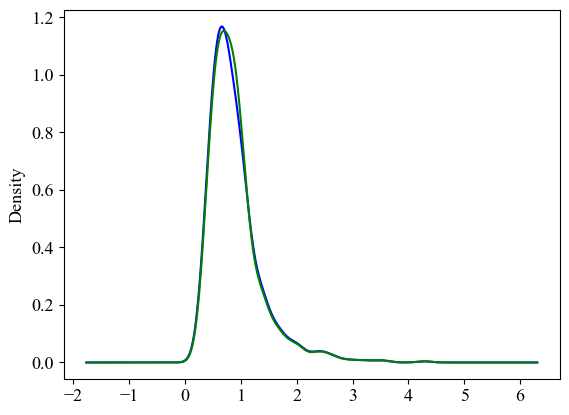

In [399]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff5[continuous])
train_t = imputer.transform(dff5[continuous])
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff5[continuous].columns)

fig = plt.figure()
ax = fig.add_subplot(111)
dff5['triglycerides_phase1'].plot(kind='kde', ax=ax, color='blue')
treated['triglycerides_phase1'].plot(kind='kde', ax=ax, color='green')

In [418]:
dff4 = dff4[features + target_cols].copy()
dff4.reset_index(inplace=True, drop=True)
dff4[continuous] = treated[continuous]
dff4['age_phase1'] = dff4.age_phase1.astype(int)

In [426]:
# defining the expectations as mean of the target
dff4['expectation'] = .157442
dff4['expectation'].head()

0    0.157442
1    0.157442
2    0.157442
3    0.157442
4    0.157442
Name: expectation, dtype: float64

In [423]:
dff4[target_cols].mean()

diabetes_status_c_phase2    0.157442
dtype: float64

In [429]:
# Defining the search space to be all the features except site, study_id, 
# and our created target_col and expectations columns

search_space1 = [col for col in dff.columns \
                if col not in \
                ['age_phase2','index','site',
       'diabetes_status_c_phase2', 'hypertension_status_phase2',
       'smoking_status_c_phase2', 'diabetes_history_phase2', 'mvpa_c_phase2',
       'weight_phase2', 'bmi_c_phase2', 'waist_circumference_phase2',
       'waist_hip_r_c_phase2', 'bp_sys_average_phase2','hypertension_status_c_phase1','diabetes_status_c_phase1','non_hdl_c_phase1',
       'bp_dia_average_phase2', 'fasting_confirmed_phase2','hip_circumference_phase1', 'hip_circumference_phase2',
       'glucose_result_phase2', 's_creatinine_phase2', 'insulin_result_phase2', 'cholesterol_1_phase2', 'friedewald_ldl_c_phase2',
       'triglycerides_phase2', 'non_hdl_c_phase2', 'egfr_c_phase2','acr_c_phase2', 'change_in_weight', 'change_in_bmi','change_in_diastolic_ave',
       'change_in_cholesterol', 'change_in_friedewald', 'change_in_hdl', 'bp_sys_average_phase1','ckd_c_phase1', 'bp_dia_average_phase1', 'acr_c_phase1',
 'cvd_status_phase1','insulin_result_phase1','hdl_phase2','fasting_confirmation_phase1','weight_phase1','partnership_status_c_phase1',
       'change_in_s_creatinine', 'change_in_insulin', 'change_in_non_hdl','s_creatinine_phase1', 'glucose_result_phase1', 
       'change_in_egfr', 'change_in_acr', 'MAP_phase1',#'diabetes_history_phase1', 'mvpa_c_phase1', 
       'MAP_phase2', 'MorbidityCount', 'expectation3','expectationPoisson']]

In [430]:
(search_space1)

['age_phase1',
 'sex',
 'highest_level_of_education_phase1',
 'ses_site_quintile_c_phase1',
 'occupation_phase1',
 'alcohol_use_status_c_phase1',
 'smoking_status_c_phase1',
 'diabetes_history_phase1',
 'mvpa_c_phase1',
 'bmi_c_phase1',
 'waist_hip_r_c_phase1',
 'waist_circumference_phase1',
 'hdl_phase1',
 'cholesterol_1_phase1',
 'friedewald_ldl_c_phase1',
 'triglycerides_phase1',
 'egfr_c_phase1']

In [431]:
def get_str(x):
    # This function turns a pandas bin to a meaningful string
    s = str(round(x.left, 2)) + ' - ' + str(round(x.right,2))
    return s

def custom_qcut(ser, contiguous = True):
    # Get the rows that are actual numbers
    sub_ser = ser[(ser != -111) \
                     & (ser != -222) \
                     & (ser != -555) \
                     & (ser != -999)]
    
    if contiguous:
        # if contiguous, treat all the special numbers the same
        ser = ser.replace(-111 , -999)
        ser = ser.replace(-222 , -999)
        ser = ser.replace(-555 , -999)

    # Bin the actual numbers into 10 bins for scanning
    sub_ser = pd.qcut(sub_ser, 10, duplicates='drop')
    sub_ser = sub_ser.apply(get_str).astype(str)
    ser[list(sub_ser.index)] = sub_ser
    return ser
            

In [432]:
contiguous = {}
dff_2 = dff4.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space1:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [434]:
def compress_contiguous(subset, contiguous):
    # Shorten a contiguous list e.g [0-9, 10-19] is converted to [0 - 19] 
    new = {}
    
    for col in subset:
        if col in contiguous:
            if isinstance(subset[col][0], (float,int)):
                new[col] = [str(c) for c in subset[col]]
                continue
            i = -1 if isinstance(subset[col][-1], str) else -2
            new[col] = [subset[col][0].split(' - ')[0] + ' - ' + subset[col][i].split(' - ')[-1]]
            new[col] = new[col] if i == -1 else new[col] + [str(subset[col][-1])]
        else:
            new[col] = [str(c) for c in subset[col]]
    return new

def translate_subset_to_rule(subset):
    # Print the subset as a rule for easier understanding
    desc = ''
    for key, value in subset.items():
        # desc += key + ' = {' + ' OR '.join(value) + '} AND' + '\n'
        desc += key + '{' + ' OR '.join(value) + '} AND' + ' '

    return desc[:-5].replace('_',' ').replace('{', '[').replace('}', ']')

def count_conditions(subset):
    # Split the string by 'AND' and 'OR'
    conditions = subset.replace("AND", "OR").split("OR")
    
    # Count the number of conditions
    condition_count = len(conditions)
    
    return condition_count

In [435]:
dff_2.columns

Index(['age_phase1', 'sex', 'highest_level_of_education_phase1',
       'partnership_status_c_phase1', 'ses_site_quintile_c_phase1',
       'occupation_phase1', 'alcohol_use_status_c_phase1',
       'smoking_status_c_phase1', 'diabetes_history_phase1', 'mvpa_c_phase1',
       'weight_phase1', 'bmi_c_phase1', 'waist_hip_r_c_phase1',
       'waist_circumference_phase1', 'bp_sys_average_phase1',
       'bp_dia_average_phase1', 'glucose_result_phase1', 's_creatinine_phase1',
       'hdl_phase1', 'cholesterol_1_phase1', 'friedewald_ldl_c_phase1',
       'triglycerides_phase1', 'egfr_c_phase1', 'acr_c_phase1',
       'diabetes_status_c_phase2', 'change_in_weight', 'change_in_bmi',
       'change_in_waist_hip_ratio', 'change_in_waist_circf',
       'change_in_systolic_ave', 'change_in_diastolic_ave',
       'change_in_cholesterol', 'change_in_friedewald', 'change_in_hdl',
       'change_in_triglycerides', 'change_in_glucose',
       'change_in_s_creatinine', 'change_in_insulin', 'change_in_no

In [437]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
# penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
penalty_values = [1.0, 1.5, 2, 2.5, 3.0,3.5]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
odds_results = []
count_results = []
dataframes = {}

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space1], dff_2[target_cols], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]

    # Store each DataFrame in the dictionary with a unique key
    dataframes[f'df_{penalty}'] = temp_df

    size = len(temp_df)
    observed_income = np.round(temp_df[target_cols].mean(), 3)
    positive_class_count = temp_df[target_cols].sum()

    group_obs = temp_df[target_cols].mean()
    group_prob = temp_df['expectation'].mean()
    odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))
    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(np.round(score, 3))
    size_results.append(size)
    odds_results.append(np.round(odds_mul, 3))
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)


# # Display the results for each penalty value
# for i, penalty in enumerate(penalty_values):
#     print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, Odds = {odds_results[i]}, Score = {score_results[i]}")

Penalty = 1.0: Subset = age phase1[46.0 - 70.0] AND ses site quintile c phase1[4 OR 5] AND bmi c phase1[28.39 - 54.29] AND triglycerides phase1[0.98 - 4.29], 
LiteralsNumber = 5, 
Size = 53, Odds = diabetes_status_c_phase2    5.557
dtype: float64, Score = 12.642
Penalty = 1.5: Subset = mvpa c phase1[120.0 - 2400.0] AND age phase1[42.0 - 70.0] AND waist hip r c phase1[0.87 - 1.16] AND hdl phase1[1.16 - 1.28] AND occupation phase1[1 OR 4] AND triglycerides phase1[0.98 - 4.29], 
LiteralsNumber = 7, 
Size = 14, Odds = diabetes_status_c_phase2    inf
dtype: float64, Score = 15.382
Penalty = 2: Subset = triglycerides phase1[1.11 - 4.29] AND waist hip r c phase1[1.0 - 1.16] AND waist circumference phase1[990.0 - 1420.0], 
LiteralsNumber = 3, 
Size = 29, Odds = diabetes_status_c_phase2    10.168
dtype: float64, Score = 12.157
Penalty = 2.5: Subset = waist circumference phase1[990.0 - 1420.0] AND waist hip r c phase1[1.0 - 1.16] AND triglycerides phase1[1.11 - 4.29], 
LiteralsNumber = 3, 
Size 

In [440]:
dff4.shape

(813, 44)

In [411]:
data1[(data1['site'] == 3)].diabetes_status_c_phase1.value_counts()

0    1810
1     132
Name: diabetes_status_c_phase1, dtype: int64